In [1]:
pip install faker

Note: you may need to restart the kernel to use updated packages.


In [177]:
pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 15.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.0 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [463]:
pip install pmdarima

  Using cached Cython-3.0.11-py2.py3-none-any.whl.metadata (3.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.9 MB/s eta 0:00:00 0:00:01
Using cached Cython-3.0.11-py2.py3-none-any.whl (1.2 MB)
Note: you may need to restart the kernel to use updated packages.


In [187]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [282]:
from faker import Faker
import pandas as pd
import random
from datetime import timedelta
import numpy as np
import plotly.graph_objects as go
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin

In [6]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Synthetic Data Generation 

In [9]:
fake = Faker()

In [11]:
supplier1_df = pd.read_csv('data/supplier1_feeder.csv')
supplier2_df = pd.read_csv('data/supplier2_feeder.csv')
supplier3_df = pd.read_csv('data/supplier3_feeder.csv')
supplier4_df = pd.read_csv('data/supplier4_feeder.csv')
supplier5_df = pd.read_csv('data/supplier5_feeder.csv')
supplier6_df = pd.read_csv('data/supplier6_feeder.csv')
supplier7_df = pd.read_csv('data/supplier7_feeder.csv')
supplier8_df = pd.read_csv('data/supplier8_feeder.csv')
supplier9_df = pd.read_csv('data/supplier9_feeder.csv')
supplier10_df = pd.read_csv('data/supplier10_feeder.csv')
supplier11_df = pd.read_csv('data/supplier11_feeder.csv')
supplier12_df = pd.read_csv('data/supplier12_feeder.csv')
supplier13_df = pd.read_csv('data/supplier13_feeder.csv')
supplier14_df = pd.read_csv('data/supplier14_feeder.csv')

In [13]:

# Helper function to create invoices with stock-based amounts and volumes
def create_supplier_invoices_and_payments(feeder, supplier_name):
    
    # Random Parameter Assignments
    payment_terms_days = [30, 45, 60, 90]
    payee_types = ['Supplier', 'Contingent Worker', 'Ad Hoc Payee']
    items = ['Laptop', 'Desk', 'Chairs', 'Monitor', 'Food', 'Beverages']
    categories = ['Materials', 'Consulting', 'IT Services', 'Marketing']
    supplier_ratings = ['High', 'Medium', 'Low']
    supplierBanks = ['Chase', 'BOA', 'WellsFargo']
    companyBanks = ['Chase', 'BOA', 'WellsFargo']
    paymentTypes = ['Check', 'Cash', 'Direct Deposit', 'Zelle']
    feeder['Date'] = pd.to_datetime(feeder['Date']).dt.date

    # Create invoices and payments
    invoice_data = []
    payment_data = []

    for _, row in feeder.iterrows():
        for _ in range(1):  # Generate one invoice per date
            # Generate invoice details
            invoice_id = fake.unique.bothify(text="INV#################")
            company = 'Company A'
            currency = 'USD'
            item = random.choice(items)
            quantity = row['Rough_Volume']
            category = random.choice(categories)
            payee_type = random.choice(payee_types)
            supplier_rating = random.choice(supplier_ratings)
            urgency = random.choice(['High', 'Normal'])
            payment_term = random.choice(payment_terms_days)

            # Invoice amount within stock's low and high prices
            original_amount = round(random.uniform(row['Starting_Inv_Amount'], row['Ending_Inv_Amount']),2)

            # Create invoice record
            invoice_data.append([
                supplier_name, invoice_id, company, currency, item, quantity, category, payee_type,
                supplier_rating, urgency, row['Date'], original_amount, payment_term
            ])

            # Generate payment details
            total_payment = 0
            num_payments = random.choice([0, 1, 2, 3])  # Randomize partial payments
            supplierBank = random.choice(supplierBanks)
            companyBank = random.choice(companyBanks)
            paymentType = random.choice(paymentTypes)
            for _ in range(num_payments):
                payment_amount = round(original_amount / num_payments, 2)
                payment_date = row['Date'] + timedelta(days=30)  # Payment always a month later
                payment_data.append([
                    invoice_id, payment_date, payment_amount, paymentType, supplierBank, companyBank
                ])
                total_payment += payment_amount

            # Determine payment status based on total payments
            payment_status = (
                'Paid' if total_payment >= original_amount else
                'Partially Paid' if 0 < total_payment < original_amount else
                'Unpaid'
            )

            # Update the invoice with payment status
            invoice_data[-1].append(payment_status)

    # Create DataFrames
    supplier_invoices_df = pd.DataFrame(invoice_data, columns=[
        'Supplier Name', 'Invoice ID', 'Company', 'Currency', 'Item', 'Quantity', 'Category', 'Payee Type',
        'Supplier Rating', 'Urgency', 'Invoice Date', 'Invoice Amount', 'Payment Term Days',
        'Payment Status'
    ])

    payment_details_df = pd.DataFrame(payment_data, columns=[
        'Invoice ID', 'Payment Date', 'Payment Amount', 'Payment Type', 'Supplier Bank', 'Company Bank'
    ])

    return supplier_invoices_df, payment_details_df


In [15]:
# Generate invoices and payments data frame
supplier1_invoices, supplier1_payments = create_supplier_invoices_and_payments(supplier1_df, 'Supplier 1')
supplier2_invoices, supplier2_payments = create_supplier_invoices_and_payments(supplier2_df, 'Supplier 2')
supplier3_invoices, supplier3_payments = create_supplier_invoices_and_payments(supplier3_df, 'Supplier 3')
supplier4_invoices, supplier4_payments = create_supplier_invoices_and_payments(supplier4_df, 'Supplier 4')
supplier5_invoices, supplier5_payments = create_supplier_invoices_and_payments(supplier5_df, 'Supplier 5')
supplier6_invoices, supplier6_payments = create_supplier_invoices_and_payments(supplier6_df, 'Supplier 6')
supplier7_invoices, supplier7_payments = create_supplier_invoices_and_payments(supplier7_df, 'Supplier 7')
supplier8_invoices, supplier8_payments = create_supplier_invoices_and_payments(supplier8_df, 'Supplier 8')
supplier9_invoices, supplier9_payments = create_supplier_invoices_and_payments(supplier9_df, 'Supplier 9')
supplier10_invoices, supplier10_payments = create_supplier_invoices_and_payments(supplier10_df, 'Supplier 10')
supplier11_invoices, supplier11_payments = create_supplier_invoices_and_payments(supplier11_df, 'Supplier 11')
supplier12_invoices, supplier12_payments = create_supplier_invoices_and_payments(supplier12_df, 'Supplier 12')
supplier13_invoices, supplier13_payments = create_supplier_invoices_and_payments(supplier13_df, 'Supplier 13')
supplier14_invoices, supplier14_payments = create_supplier_invoices_and_payments(supplier14_df, 'Supplier 14')

In [16]:
# Combined data frames result
supplier_invoices_df = pd.concat([supplier1_invoices, supplier2_invoices, supplier3_invoices, supplier4_invoices, 
                                  supplier5_invoices, supplier6_invoices, supplier7_invoices, supplier8_invoices, 
                                  supplier9_invoices, supplier10_invoices, supplier11_invoices, supplier12_invoices, 
                                  supplier13_invoices, supplier14_invoices], ignore_index=True)
payment_details_df = pd.concat([supplier1_payments, supplier2_payments, supplier3_payments, supplier4_payments, 
                                  supplier5_payments, supplier6_payments, supplier7_payments, supplier8_payments, 
                                  supplier9_payments, supplier10_payments, supplier11_payments, supplier12_payments, 
                                  supplier13_payments, supplier14_payments], ignore_index=True)

In [19]:
supplier_invoices_df.head()

,Supplier Name,Invoice ID,Company,Currency,Item,Quantity,Category,Payee Type,Supplier Rating,Urgency,Invoice Date,Invoice Amount,Payment Term Days,Payment Status
0,Supplier 1,INV72785995514984247,Company A,USD,Monitor,48475,Materials,Supplier,High,Normal,2015-01-01,928.89,30,Paid
1,Supplier 1,INV21687692716227576,Company A,USD,Laptop,154493,Materials,Supplier,High,High,2015-01-02,921.45,90,Partially Paid
2,Supplier 1,INV12764061430913690,Company A,USD,Monitor,172236,IT Services,Contingent Worker,High,Normal,2015-01-05,940.66,60,Paid
3,Supplier 1,INV03355044634137533,Company A,USD,Laptop,114142,IT Services,Supplier,Low,Normal,2015-01-06,947.04,45,Unpaid
4,Supplier 1,INV39353885838775137,Company A,USD,Beverages,473737,Materials,Contingent Worker,Medium,High,2015-01-07,980.35,60,Partially Paid


In [21]:
payment_details_df.head()

,Invoice ID,Payment Date,Payment Amount,Payment Type,Supplier Bank,Company Bank
0,INV72785995514984247,2015-01-31,309.63,Check,BOA,WellsFargo
1,INV72785995514984247,2015-01-31,309.63,Check,BOA,WellsFargo
2,INV72785995514984247,2015-01-31,309.63,Check,BOA,WellsFargo
3,INV21687692716227576,2015-02-01,307.15,Zelle,Chase,BOA
4,INV21687692716227576,2015-02-01,307.15,Zelle,Chase,BOA


In [23]:
supplier_invoices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26367 entries, 0 to 26366
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Supplier Name      26367 non-null  object 
 1   Invoice ID         26367 non-null  object 
 2   Company            26367 non-null  object 
 3   Currency           26367 non-null  object 
 4   Item               26367 non-null  object 
 5   Quantity           26367 non-null  int64  
 6   Category           26367 non-null  object 
 7   Payee Type         26367 non-null  object 
 8   Supplier Rating    26367 non-null  object 
 9   Urgency            26367 non-null  object 
 10  Invoice Date       26367 non-null  object 
 11  Invoice Amount     26367 non-null  float64
 12  Payment Term Days  26367 non-null  int64  
 13  Payment Status     26367 non-null  object 
dtypes: float64(1), int64(2), object(11)
memory usage: 2.8+ MB


In [25]:
supplier_invoices_df.describe()

,Quantity,Invoice Amount,Payment Term Days
count,2.636700e+04,26367.000000,26367.000000
mean,2.186456e+06,2265.801523,56.290249
std,5.901302e+06,3903.008174,22.235752
min,0.000000e+00,80.900000,30.000000
25%,1.790820e+05,318.215000,45.000000
50%,6.348070e+05,638.060000,45.000000
75%,1.701819e+06,1615.915000,90.000000
max,1.856700e+08,20949.300000,90.000000


In [27]:
payment_details_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39665 entries, 0 to 39664
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Invoice ID      39665 non-null  object 
 1   Payment Date    39665 non-null  object 
 2   Payment Amount  39665 non-null  float64
 3   Payment Type    39665 non-null  object 
 4   Supplier Bank   39665 non-null  object 
 5   Company Bank    39665 non-null  object 
dtypes: float64(1), object(5)
memory usage: 1.8+ MB


In [29]:
payment_details_df.describe()

,Payment Amount
count,39665.000000
mean,1133.454896
std,2200.862596
min,26.970000
25%,146.250000
50%,304.820000
75%,841.050000
max,20445.040000


In [31]:
# Export to CSV
supplier_invoices_df.to_csv('data1/full_supplier_invoice.csv', index=False)
payment_details_df.to_csv('data1/full_supplier_invoice_payment.csv', index=False)

# Visualizations

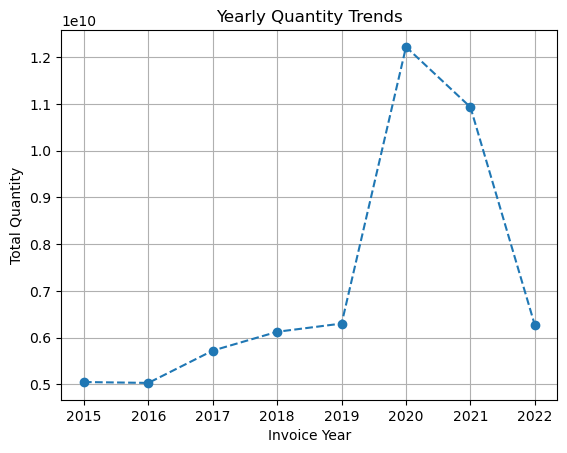

In [34]:
# Aggregate Quantity by Invoice Year
supplier_invoices_df['Invoice Date'] = pd.to_datetime(supplier_invoices_df['Invoice Date'], errors='coerce')

supplier_invoices_df['Invoice Year'] = supplier_invoices_df['Invoice Date'].dt.year

yearly_data = supplier_invoices_df.groupby('Invoice Year')['Quantity'].sum()

# Plot aggregated data
plt.plot(yearly_data.index, yearly_data.values, '--o')
plt.title('Yearly Quantity Trends')
plt.xlabel('Invoice Year')
plt.ylabel('Total Quantity')
plt.grid(True)
plt.show()

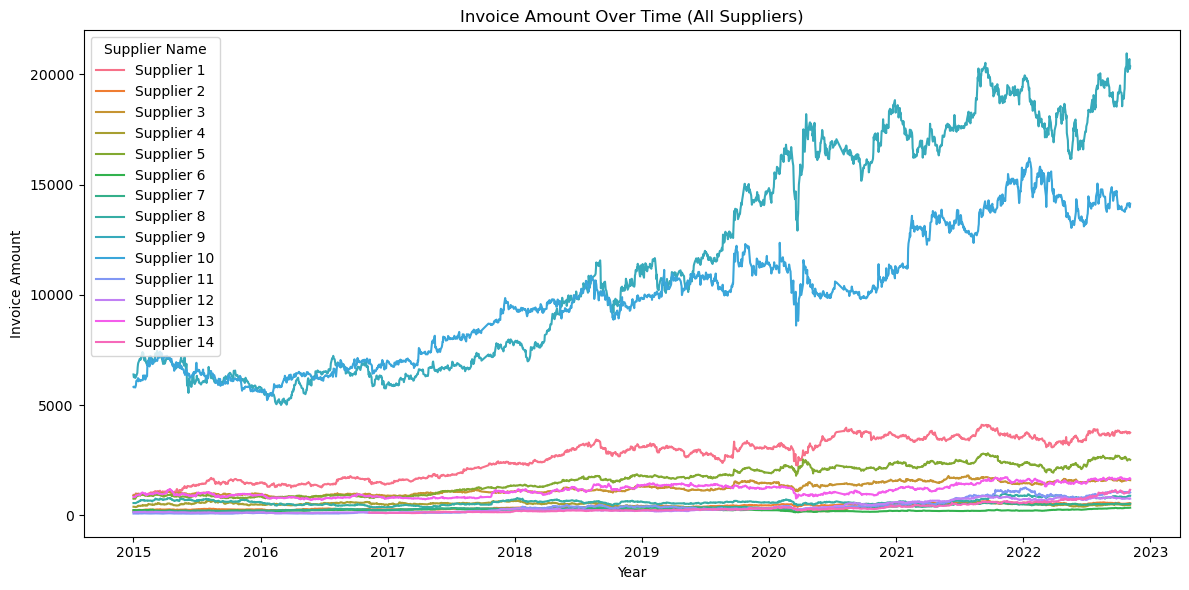

In [37]:
# Invoice Amount over Time
plt.figure(figsize=(12, 6))
sns.lineplot(data=supplier_invoices_df, x='Invoice Date', y='Invoice Amount', hue='Supplier Name')
plt.title('Invoice Amount Over Time (All Suppliers)')
plt.xlabel('Year')
plt.ylabel('Invoice Amount')
plt.legend(title='Supplier Name', loc='upper left')
plt.tight_layout()
plt.show()

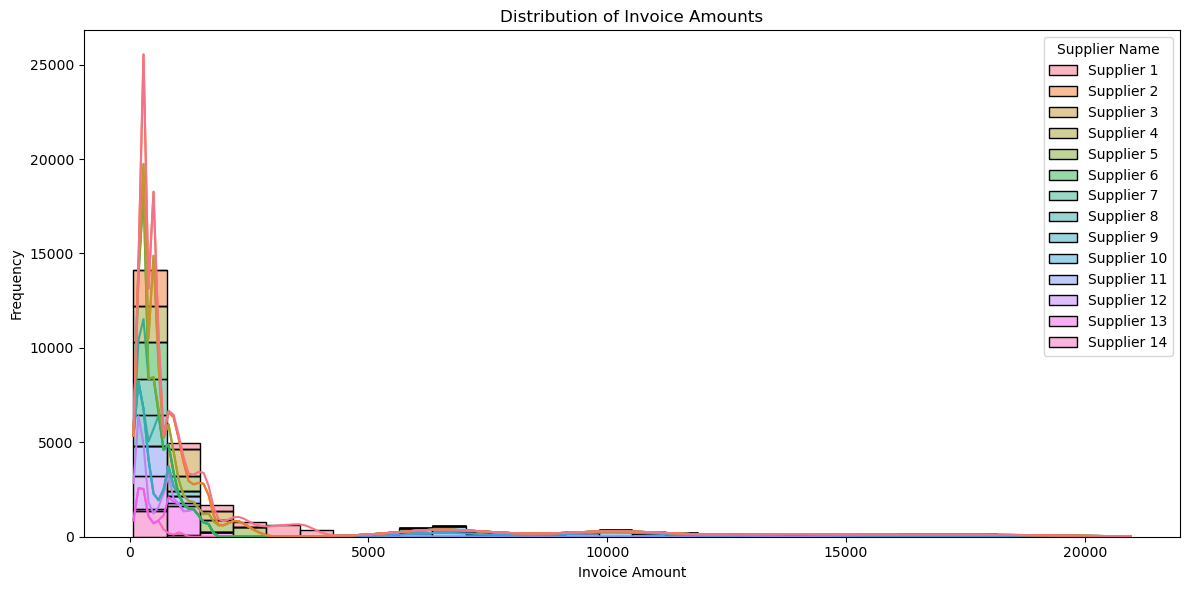

In [39]:
# Distribution of Invoice Amounts
plt.figure(figsize=(12, 6))
sns.histplot(data=supplier_invoices_df, x='Invoice Amount', bins=30, kde=True, hue='Supplier Name', multiple="stack")
plt.title('Distribution of Invoice Amounts')
plt.xlabel('Invoice Amount')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

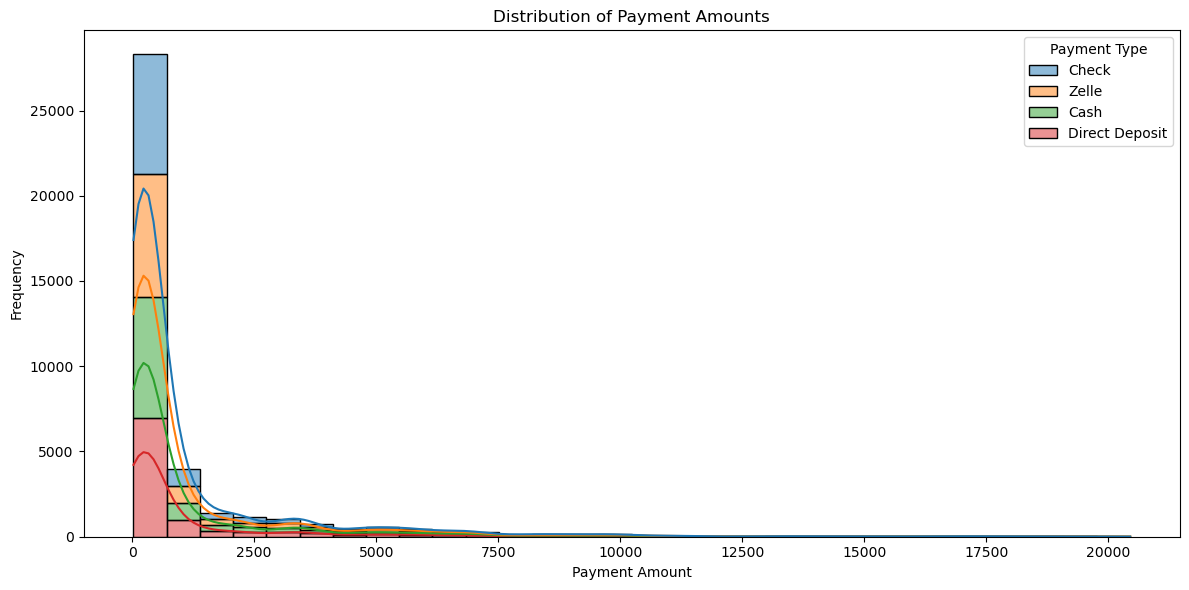

In [40]:
# Distribution of Payment Amounts
plt.figure(figsize=(12, 6))
sns.histplot(data=payment_details_df, x='Payment Amount', bins=30, kde=True, hue='Payment Type', multiple="stack")
plt.title('Distribution of Payment Amounts')
plt.xlabel('Payment Amount')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

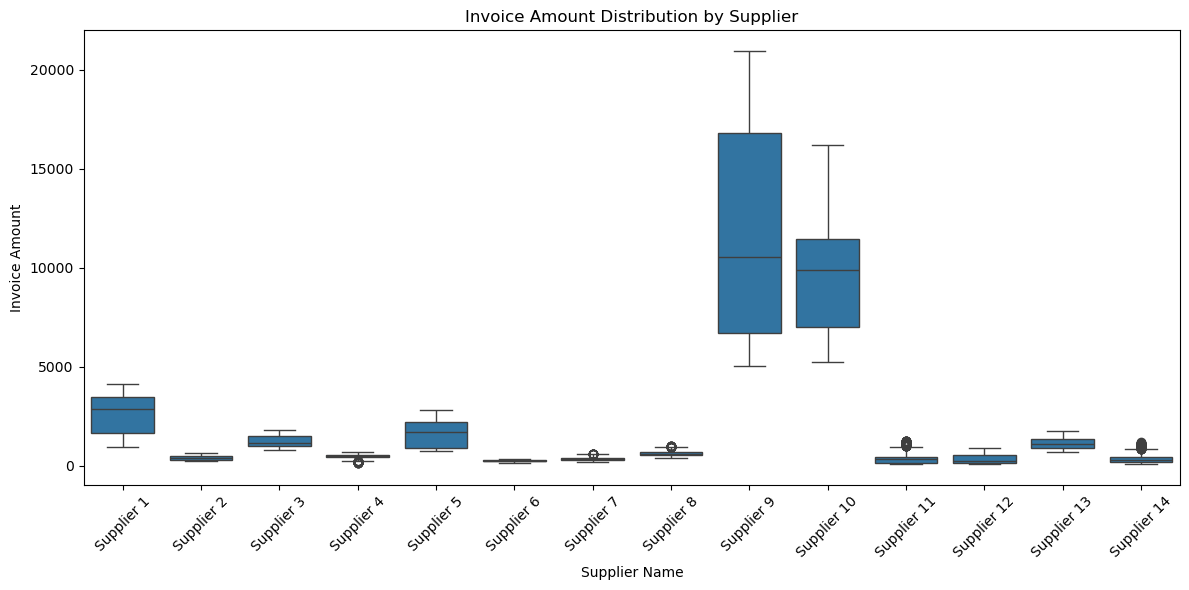

In [42]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=supplier_invoices_df, x='Supplier Name', y='Invoice Amount')
plt.xticks(rotation=45)
plt.title('Invoice Amount Distribution by Supplier')
plt.xlabel('Supplier Name')
plt.ylabel('Invoice Amount')
plt.tight_layout()
plt.show()

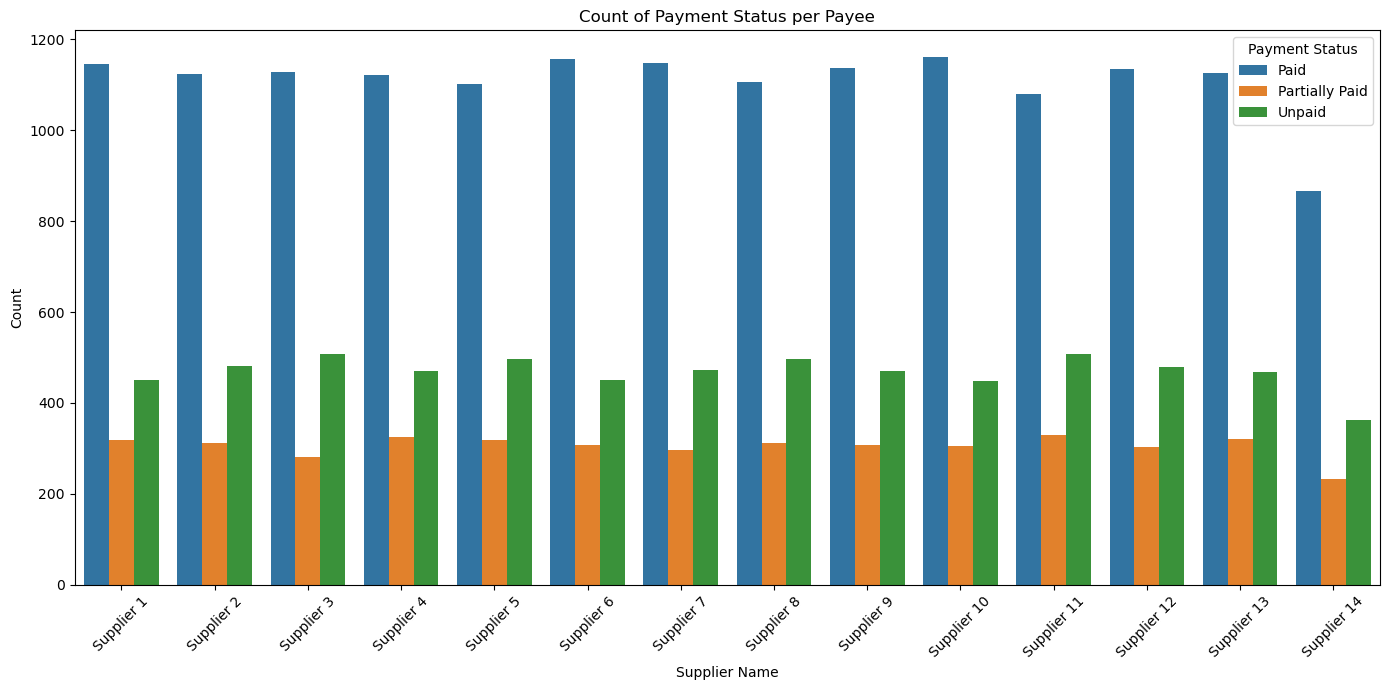

In [45]:
# Count Plot of Payment Status per Payee
plt.figure(figsize=(14, 7))
sns.countplot(data=supplier_invoices_df, x='Supplier Name', hue='Payment Status')
plt.title('Count of Payment Status per Payee')
plt.xlabel('Supplier Name')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

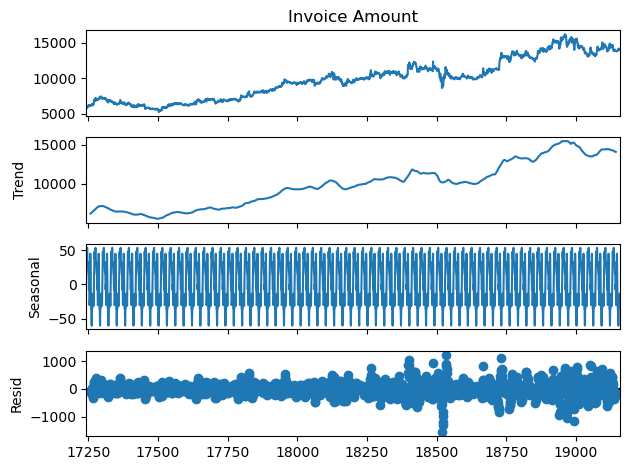

In [47]:
supplier_data = supplier_invoices_df[supplier_invoices_df['Supplier Name'] == 'Supplier 10']

decomposition = sm.tsa.seasonal_decompose(supplier_data['Invoice Amount'], model='additive', period=30)
decomposition.plot()
plt.tight_layout()
plt.show()
    

In [49]:
daily_invoices = supplier_invoices_df.groupby('Invoice Date').agg({'Invoice Amount': 'sum'}).reset_index()
daily_payments = payment_details_df.groupby('Payment Date').agg({'Payment Amount': 'sum'}).reset_index()

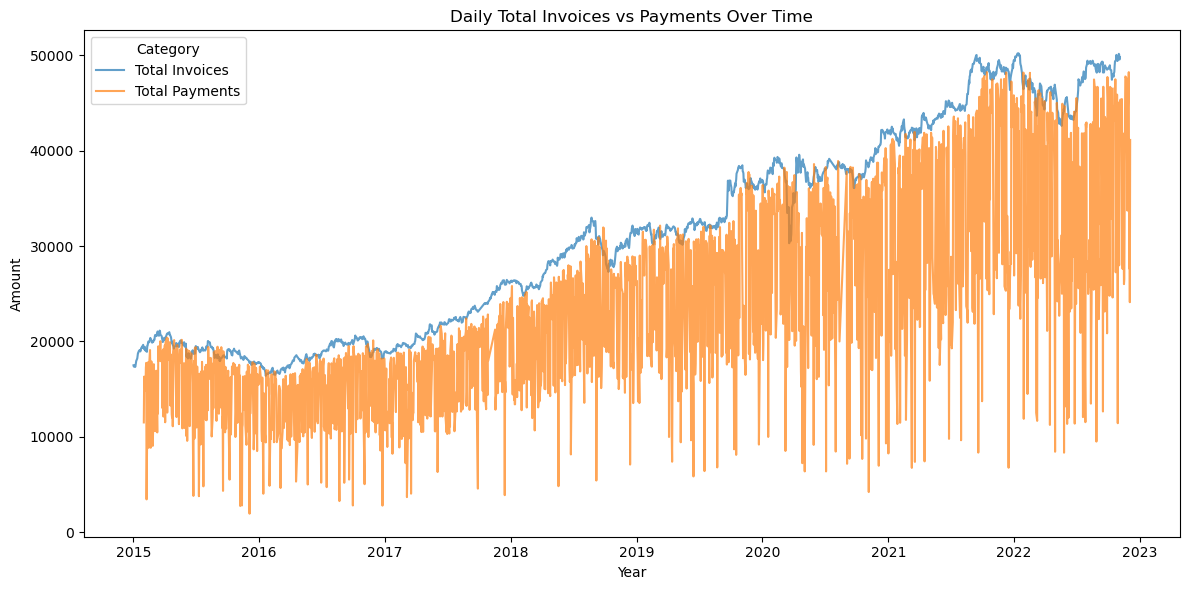

In [51]:
# Daily Total Invoices vs. Payments
plt.figure(figsize=(12, 6))
plt.plot(daily_invoices['Invoice Date'], daily_invoices['Invoice Amount'], label='Total Invoices', alpha=0.7)
plt.plot(daily_payments['Payment Date'], daily_payments['Payment Amount'], label='Total Payments', alpha=0.7)
plt.legend(title='Category', loc='upper left')
plt.title('Daily Total Invoices vs Payments Over Time')
plt.xlabel('Year')
plt.ylabel('Amount')
plt.tight_layout()
plt.show()

Data is a non-stationary time series shows trends, seasonality, or varying variance over time.
Upward/Downward Trends: A clear increasing or decreasing trajectory indicates non-stationarity.Changing Variance: If the magnitude of fluctuations increases or decreases over time, it’s likely non-stationary.

Next step is to use Augmented Dickey-Fuller (ADF) test to confirm if the data is non-stationary.
If the data is non stationary then apply differencing or log to the target variable.

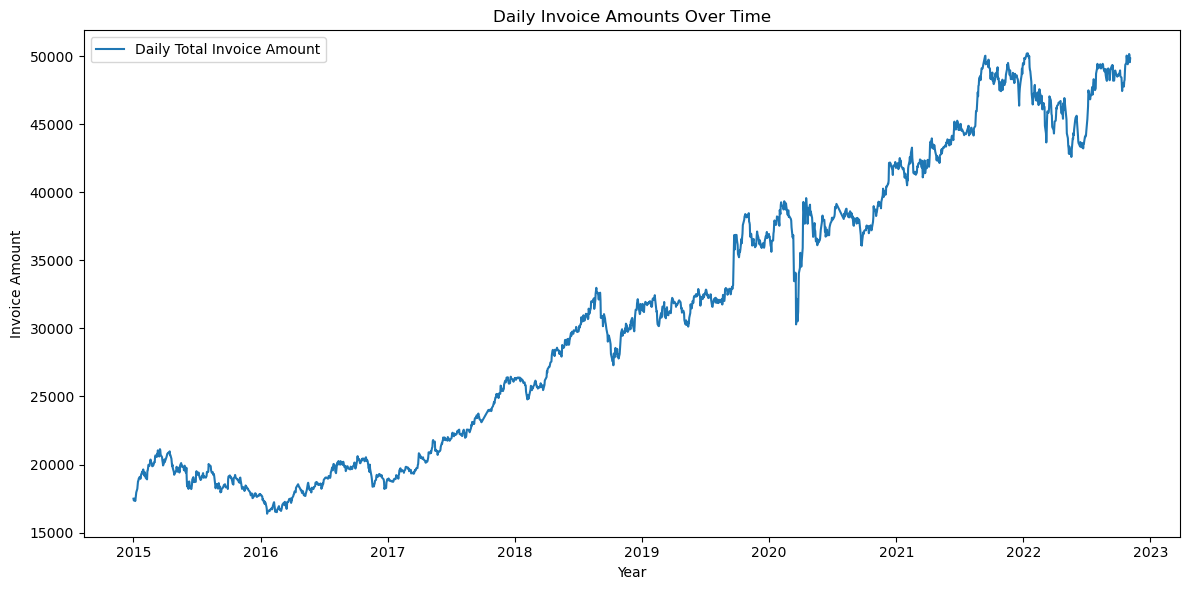

In [54]:
# Step 2: Check if the data is stationary using visualization
plt.figure(figsize=(12, 6))
plt.plot(daily_invoices['Invoice Date'], daily_invoices['Invoice Amount'], label='Daily Total Invoice Amount')
plt.title('Daily Invoice Amounts Over Time')
plt.xlabel('Year')
plt.ylabel('Invoice Amount')
plt.legend()
plt.tight_layout()
plt.show()

##### Inferences

	Non-Stationarity:
    	The slow decay of autocorrelation suggests that the time series is non-stationary.
		Stationary series typically show autocorrelations that decay quickly to zero or oscillate around zero for higher lags.
	Trend in the Data:
		The persistent positive autocorrelation indicates that the time series has a trend. This aligns with the earlier plot showing an upward trajectory in invoice amounts.
	Seasonality:
		There are no clear periodic spikes in autocorrelation at fixed lags, so strong seasonality is not immediately apparent. However, other methods like Fourier transformations or decomposition might be needed for detailed seasonal analysis.

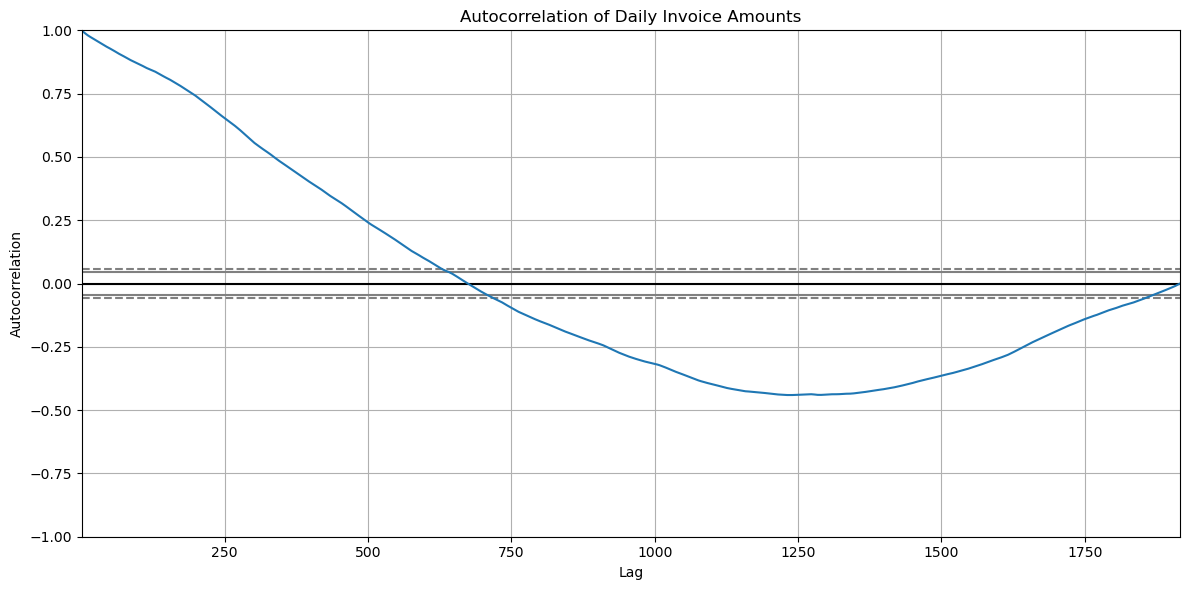

In [57]:
# Autocorrelation plot to assess seasonality or lag relationships
plt.figure(figsize=(12, 6))
autocorrelation_plot(daily_invoices['Invoice Amount'])
plt.title('Autocorrelation of Daily Invoice Amounts')
plt.tight_layout()
plt.show()

#### Sample Forecasting

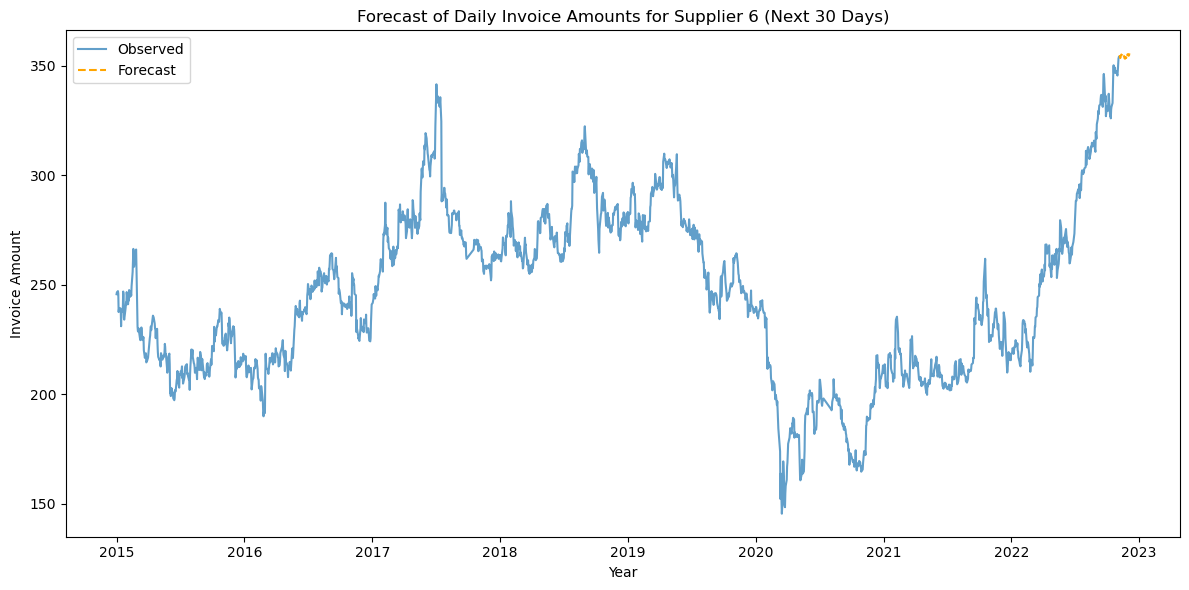

In [60]:

specific_supplier_data = supplier_invoices_df[supplier_invoices_df['Supplier Name'] == 'Supplier 6']
supplier = 'Supplier 6'
    
# Aggregate daily invoice amounts
specific_supplier_data_grouped = specific_supplier_data.groupby('Invoice Date').agg({'Invoice Amount': 'sum'}).reset_index()
specific_supplier_data_grouped.set_index('Invoice Date', inplace=True)
specific_supplier_data_grouped.index = pd.to_datetime(specific_supplier_data_grouped.index)
    
# Skip suppliers with insufficient data
if len(specific_supplier_data_grouped) < 30:
    print(f"Skipping {supplier} due to insufficient data.")
    
# Forecast using Exponential Smoothing
model = ExponentialSmoothing(specific_supplier_data_grouped['Invoice Amount'], trend='add', seasonal='add', seasonal_periods=30)
fitted_model = model.fit()
forecast_steps = 30
forecast = fitted_model.forecast(steps=forecast_steps)
forecast_dates = pd.date_range(start=specific_supplier_data_grouped.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)
    
# Plot observed data and forecast
plt.figure(figsize=(12, 6))
plt.plot(specific_supplier_data_grouped.index, specific_supplier_data_grouped['Invoice Amount'], label='Observed', alpha=0.7)
plt.plot(forecast_dates, forecast, label='Forecast', linestyle='--', color='orange')
plt.title(f'Forecast of Daily Invoice Amounts for {supplier} (Next 30 Days)')
plt.xlabel('Year')
plt.ylabel('Invoice Amount')
plt.legend()
plt.tight_layout()
plt.show()

## Payment Trends



#### Data Preparation

    Aggregate the Payment Amount by Payment Date to create a time series.
    Ensure all Payment Dates are uniformly formatted as datetime.
    Handle missing dates by imputing zeros or using forward-fill techniques.

In [66]:
payment_details_df['Payment Date'] = pd.to_datetime(payment_details_df['Payment Date'])
payment_trends = payment_details_df.groupby('Payment Date')['Payment Amount'].sum().asfreq('M', fill_value=0)

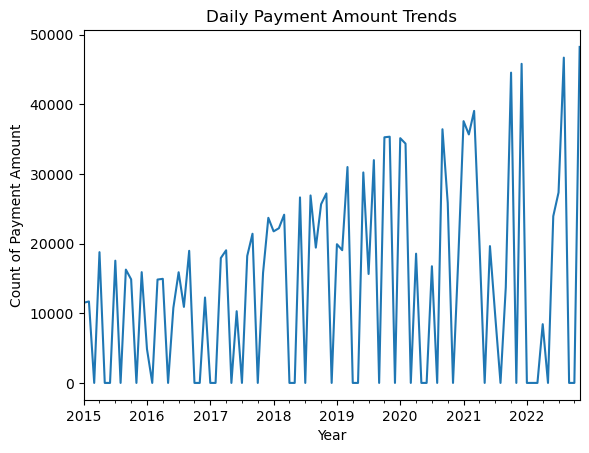

In [68]:
payment_trends.plot(title="Daily Payment Amount Trends")
plt.xlabel("Year")
plt.ylabel("Count of Payment Amount")
plt.show()

#### Comparison with the Multiplicative Model

	Seasonality:
    	
     (*) In the additive model, seasonality is constant, whereas in the multiplicative model, seasonality scales with the trend.
     (*) If the seasonal fluctuations are constant regardless of payment trends, the additive model is more appropriate.

     
	Residuals:

     (*) Residual spikes are prominent in both models, but the additive model’s residuals are less exaggerated because it assumes constant seasonal patterns.

     
    Trend:
    
     (*) The trend is similar in both models, as it represents the overall structure of the data.





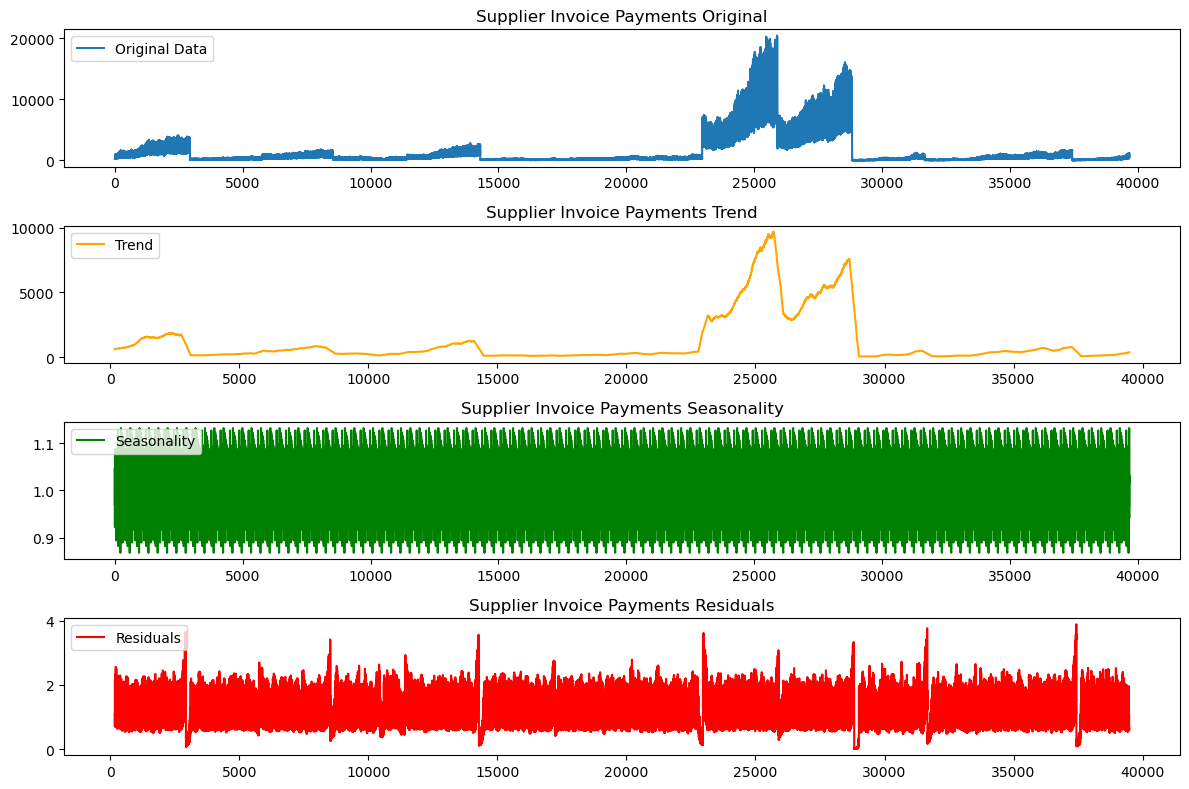

In [71]:
multiplicative_decomposition = sm.tsa.seasonal_decompose(payment_details_df['Payment Amount'], model='multiplicative', period=365)
# Plot each component with a proper title
plt.figure(figsize=(12, 8))

# Original Series
plt.subplot(4, 1, 1)
plt.plot(multiplicative_decomposition.observed, label='Original Data')
plt.title('Supplier Invoice Payments Original')
plt.legend(loc='upper left')

# Trend Component
plt.subplot(4, 1, 2)
plt.plot(multiplicative_decomposition.trend, label='Trend', color='orange')
plt.title('Supplier Invoice Payments Trend')
plt.legend(loc='upper left')

# Seasonal Component
plt.subplot(4, 1, 3)
plt.plot(multiplicative_decomposition.seasonal, label='Seasonality', color='green')
plt.title('Supplier Invoice Payments Seasonality')
plt.legend(loc='upper left')

# Residuals
plt.subplot(4, 1, 4)
plt.plot(multiplicative_decomposition.resid, label='Residuals', color='red')
plt.title('Supplier Invoice Payments Residuals')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

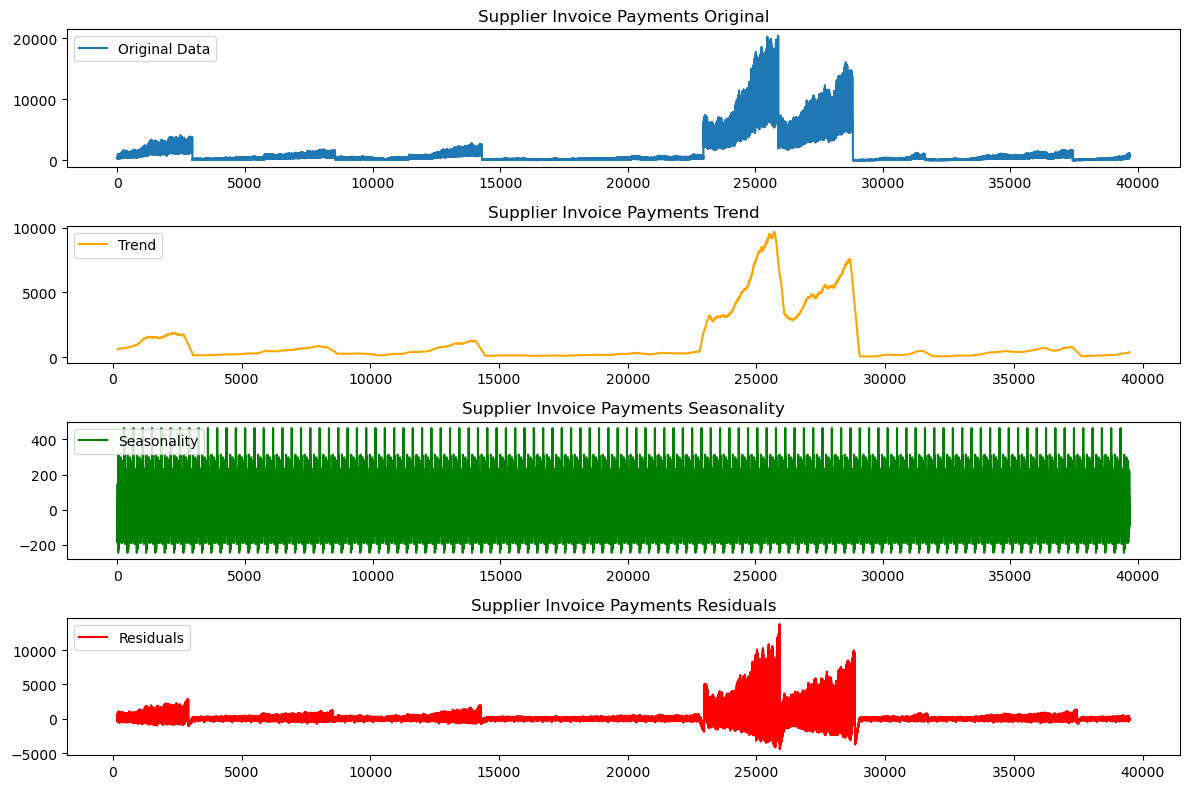

In [72]:
additive_decomposition = sm.tsa.seasonal_decompose(payment_details_df['Payment Amount'], model='additive', period=365)
# Plot each component with a proper title
plt.figure(figsize=(12, 8))

# Original Series
plt.subplot(4, 1, 1)
plt.plot(additive_decomposition.observed, label='Original Data')
plt.title('Supplier Invoice Payments Original')
plt.legend(loc='upper left')

# Trend Component
plt.subplot(4, 1, 2)
plt.plot(additive_decomposition.trend, label='Trend', color='orange')
plt.title('Supplier Invoice Payments Trend')
plt.legend(loc='upper left')

# Seasonal Component
plt.subplot(4, 1, 3)
plt.plot(additive_decomposition.seasonal, label='Seasonality', color='green')
plt.title('Supplier Invoice Payments Seasonality')
plt.legend(loc='upper left')

# Residuals
plt.subplot(4, 1, 4)
plt.plot(additive_decomposition.resid, label='Residuals', color='red')
plt.title('Supplier Invoice Payments Residuals')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

#### Comparing STD and MAE for residuals multiplicative and additive models

    Based on the metrics multiplicative model is best suited. Significant spikes in Residual Visualization suggets missing features or anomolies. 

Standard Deviation of Additive Residuals: 1086.7486821251448
Standard Deviation of Multiplicative Residuals: 0.49888272885473445
MAE of Additive Residuals: 439.73938872689416
MAE of Multiplicative Residuals: 0.987668132837869


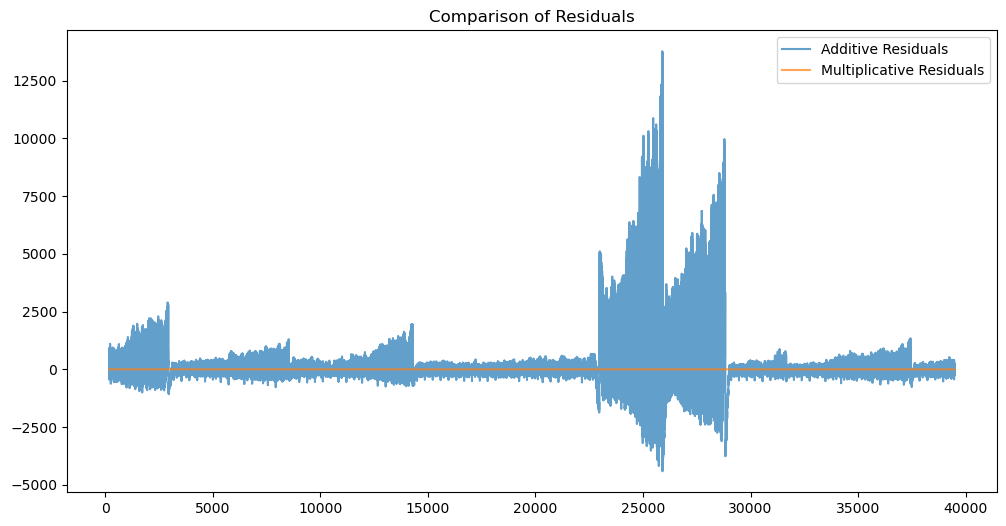

In [76]:
# Extract residuals
additive_residuals = additive_decomposition.resid.dropna()
multiplicative_residuals = multiplicative_decomposition.resid.dropna()

# Compare standard deviation of residuals
print("Standard Deviation of Additive Residuals:", np.std(additive_residuals))
print("Standard Deviation of Multiplicative Residuals:", np.std(multiplicative_residuals))

# Compare MAE of residuals
additive_mae = np.mean(np.abs(additive_residuals))
multiplicative_mae = np.mean(np.abs(multiplicative_residuals))
print("MAE of Additive Residuals:", additive_mae)
print("MAE of Multiplicative Residuals:", multiplicative_mae)

# Visualize residuals
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(additive_residuals, label="Additive Residuals", alpha=0.7)
plt.plot(multiplicative_residuals, label="Multiplicative Residuals", alpha=0.7)
plt.title("Comparison of Residuals")
plt.legend()
plt.show()

In [78]:
payment_details = payment_details_df

ADF Statistic: -2.8167566385912726
p-value: 0.05591977979688416
Data is non-stationary. Differencing is required.


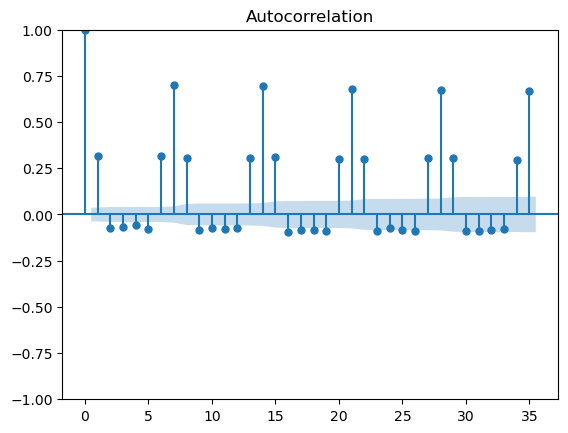

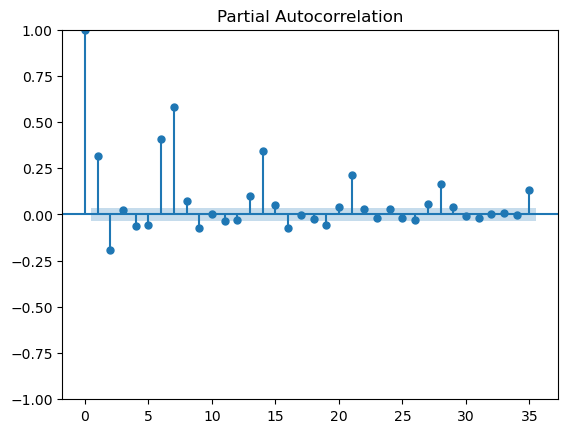

In [80]:
payment_details['Payment Date'] = pd.to_datetime(payment_details['Payment Date'])
payment_details.set_index('Payment Date', inplace=True)
daily_payment = payment_details[['Payment Amount']].resample('D').sum()
result = adfuller(daily_payment.dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] > 0.05:
    print("Data is non-stationary. Differencing is required.")
else:
    print("Data is stationary. Proceed with ARIMA.")

plot_acf(daily_payment.dropna())
plot_pacf(daily_payment.dropna())
plt.show()



ADF Statistic: -18.23247100829985
p-value: 2.3654505138571682e-30
Data is stationary. Proceed with ARIMA.


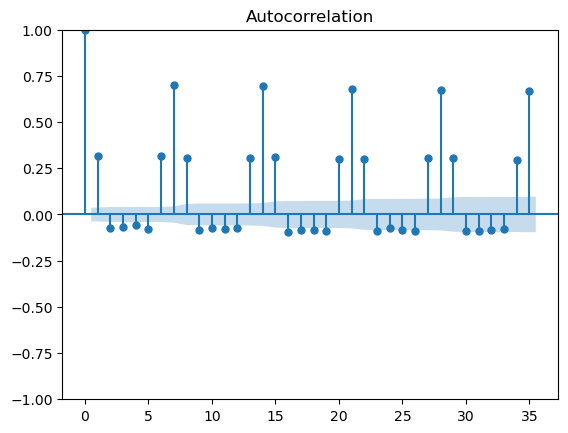

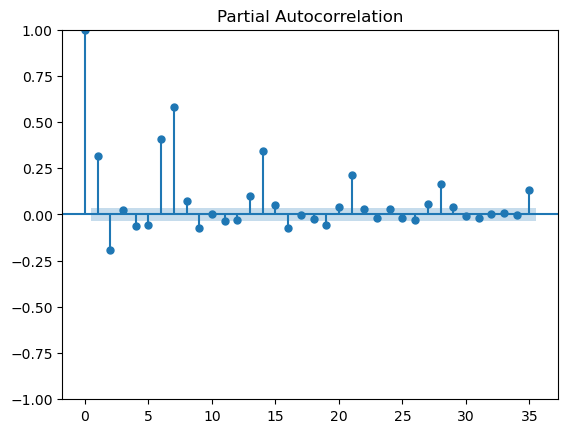

In [82]:

result = adfuller(daily_payment.diff().dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] > 0.05:
    print("Data is non-stationary. Differencing is required.")
else:
    print("Data is stationary. Proceed with ARIMA.")

plot_acf(daily_payment.dropna())
plot_pacf(daily_payment.dropna())
plt.show()

In [84]:
filtered_data = daily_payment.loc['2015':'2022']


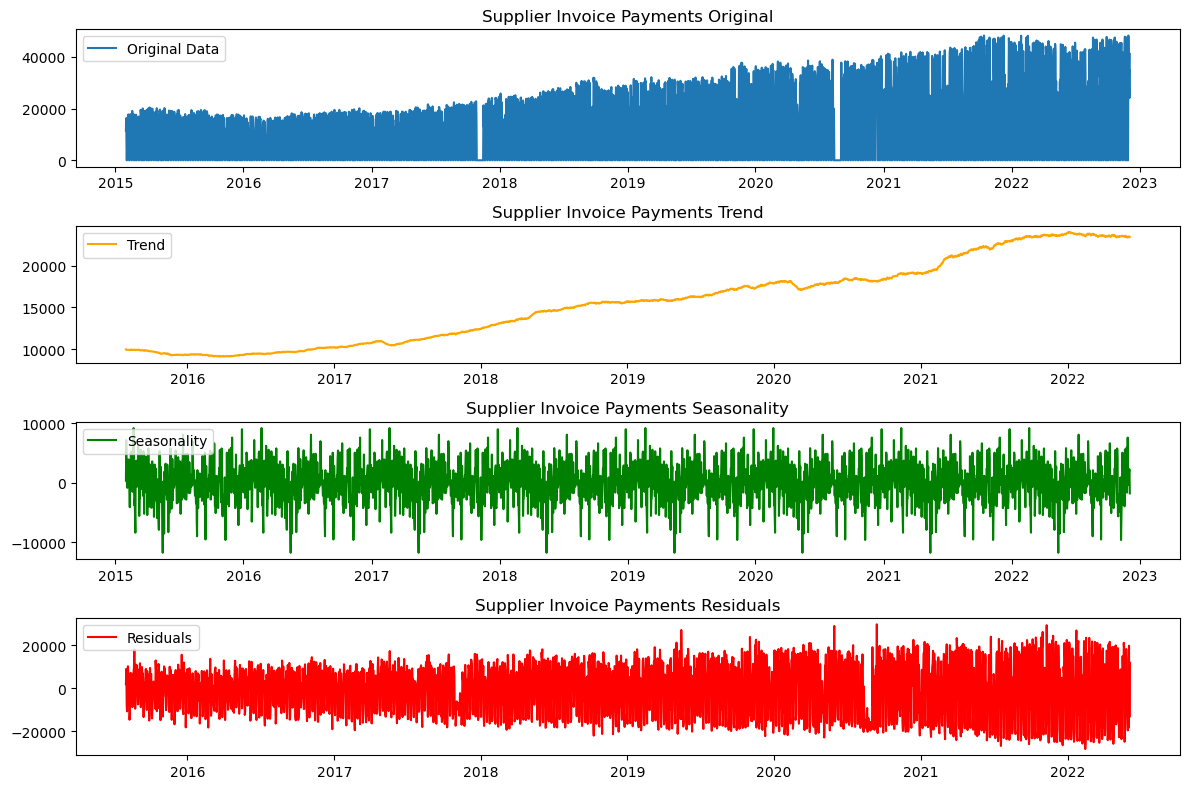

In [86]:
additive_decomposition = sm.tsa.seasonal_decompose(filtered_data['Payment Amount'], model='additive', period=365)
# Plot each component with a proper title
plt.figure(figsize=(12, 8))

# Original Series
plt.subplot(4, 1, 1)
plt.plot(additive_decomposition.observed, label='Original Data')
plt.title('Supplier Invoice Payments Original')
plt.legend(loc='upper left')

# Trend Component
plt.subplot(4, 1, 2)
plt.plot(additive_decomposition.trend, label='Trend', color='orange')
plt.title('Supplier Invoice Payments Trend')
plt.legend(loc='upper left')

# Seasonal Component
plt.subplot(4, 1, 3)
plt.plot(additive_decomposition.seasonal, label='Seasonality', color='green')
plt.title('Supplier Invoice Payments Seasonality')
plt.legend(loc='upper left')

# Residuals
plt.subplot(4, 1, 4)
plt.plot(additive_decomposition.resid, label='Residuals', color='red')
plt.title('Supplier Invoice Payments Residuals')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

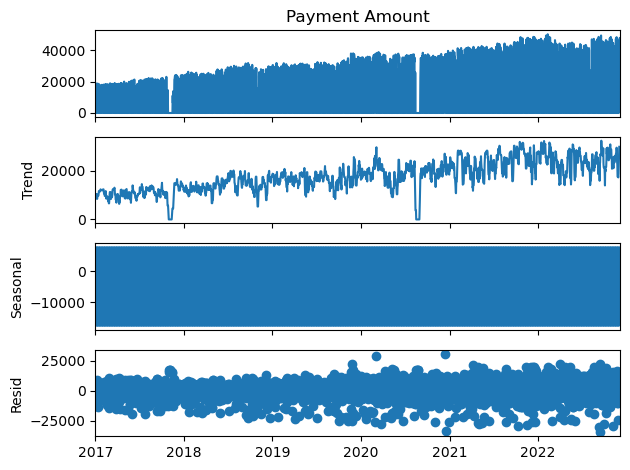

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[365] intercept   : AIC=inf, Time=1796.98 sec
 ARIMA(0,1,0)(0,0,0)[365] intercept   : AIC=48520.331, Time=0.19 sec


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming 'daily_payment' is your DataFrame and properly indexed by date
decomposition = seasonal_decompose(daily_payment['Payment Amount'], model='additive')
decomposition.plot()
plt.show()

# Explore ARIMA model fit
from pmdarima import auto_arima
#auto_model = auto_arima(daily_payment['Payment Amount'], seasonal=True, m=365, trace=True)
#print(auto_model.summary())

In [106]:
daily_payment = daily_payment.dropna()

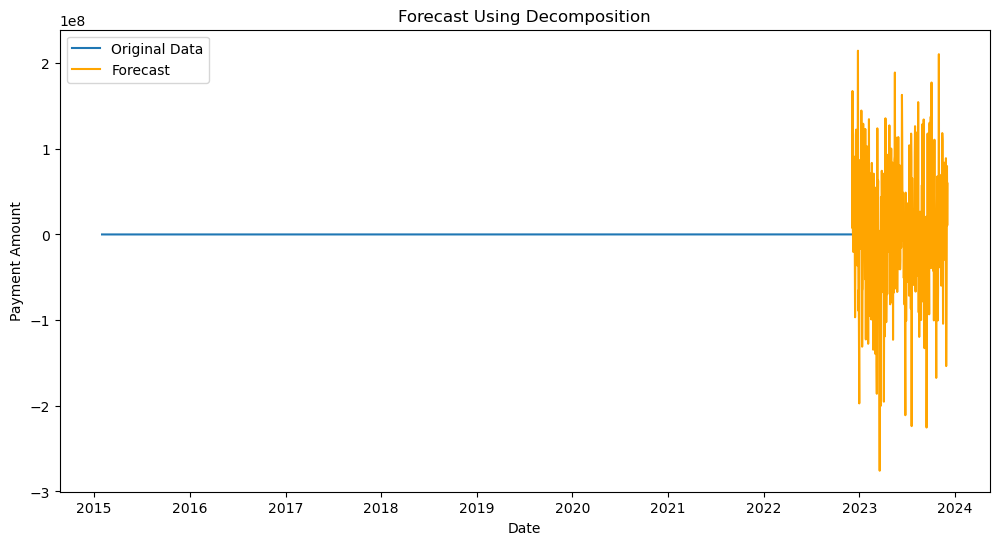

In [114]:
best_trend = additive_decomposition.trend.dropna()
best_seasonality = additive_decomposition.seasonal
best_trend.index = daily_payment.index[:len(best_trend)]

# Fit ARIMA to the trend
arima_model = ARIMA(best_trend, order=(2, 1, 2))  # Adjust (p, d, q) based on ACF/PACF
fitted_arima = arima_model.fit()

# Forecast the trend
trend_forecast = fitted_arima.forecast(steps=365)  # Forecast next 365 days

# Combine trend and seasonality
last_date = daily_payment.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=365, freq='D')
seasonality_cycle = np.tile(best_seasonality[:365], len(future_dates) // 365 + 1)[:365]  
forecast = trend_forecast * seasonality_cycle  # Use '+' for additive model

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(daily_payment.index, daily_payment['Payment Amount'], label='Original Data')
plt.plot(future_dates, forecast, label='Forecast', color='orange')
plt.title("Forecast Using Decomposition")
plt.xlabel("Date")
plt.ylabel("Payment Amount")
plt.legend()
plt.show()

<Axes: title={'center': 'ARIMA Model Residuals'}, xlabel='Payment Date'>

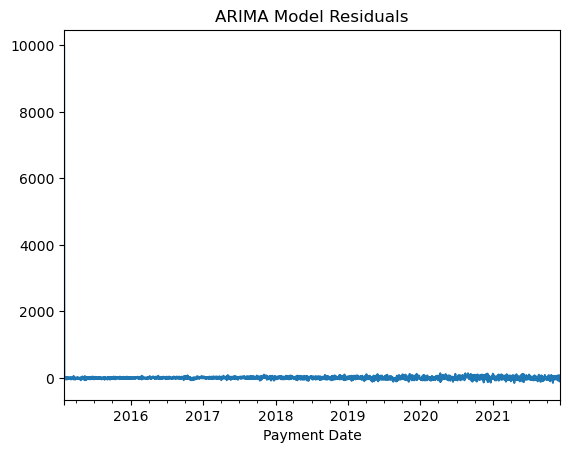

In [92]:
residuals = fitted_arima.resid
residuals.plot(title="ARIMA Model Residuals")

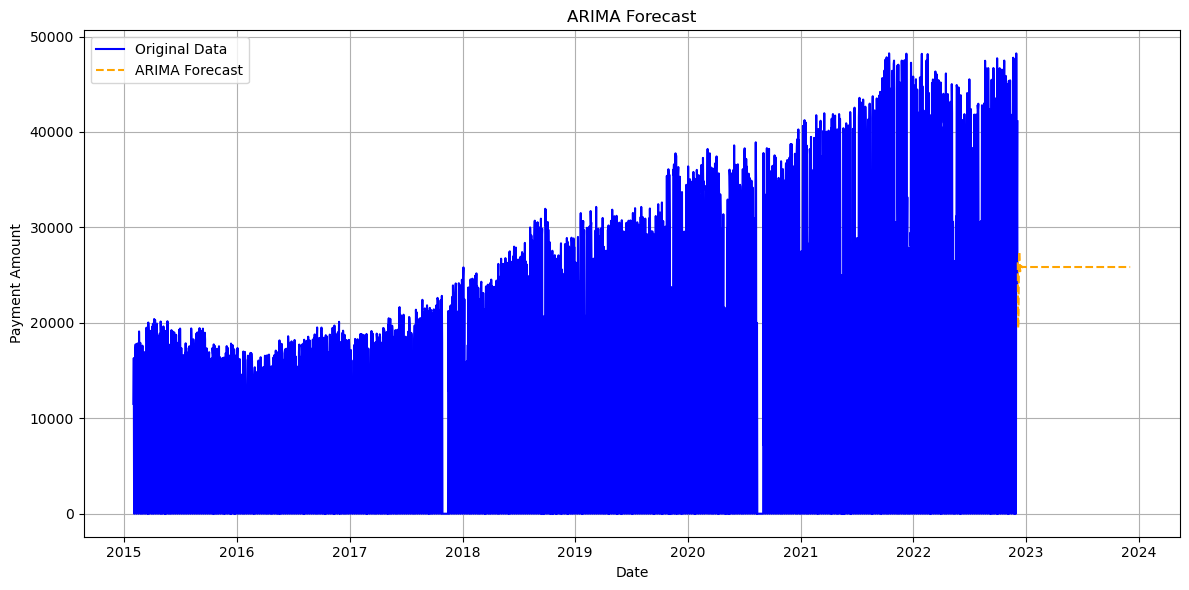

In [118]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(daily_payment['Payment Amount'], order=(2, 1, 2))  # Adjust (p, d, q)
fitted_arima = arima_model.fit()

# Forecast
trend_forecast = fitted_arima.forecast(steps=steps)

last_date = daily_payment.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=365, freq='D')

# Plot
plt.figure(figsize=(12, 6))
plt.plot(daily_payment.index, daily_payment['Payment Amount'], label="Original Data", color='blue')
plt.plot(future_dates, trend_forecast, label="ARIMA Forecast", color='orange', linestyle='--')
plt.title("ARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Payment Amount")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

16:10:49 - cmdstanpy - INFO - Chain [1] start processing
16:10:49 - cmdstanpy - INFO - Chain [1] done processing


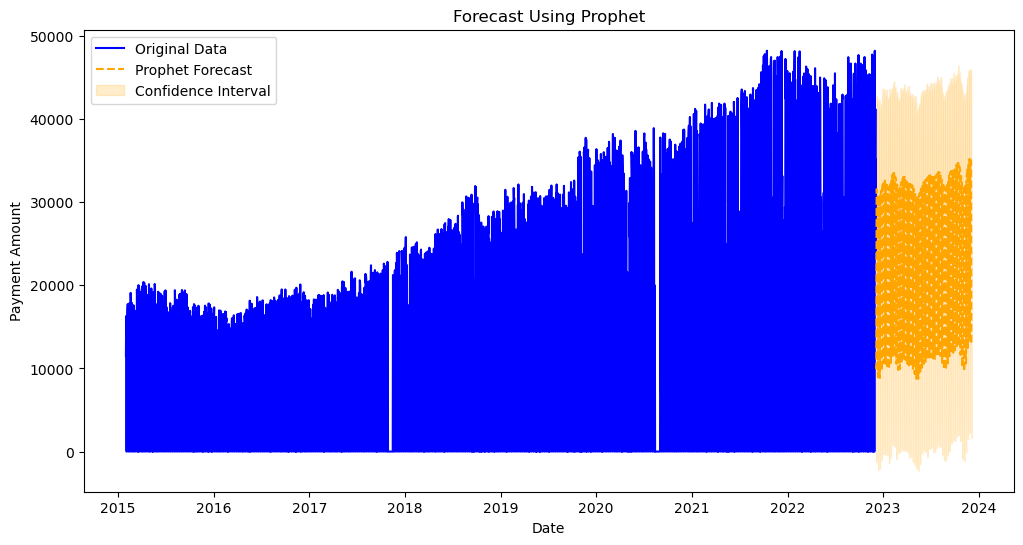

In [128]:
# Prepare data for Prophet
prophet_data = filtered_data.reset_index()[['Payment Date', 'Payment Amount']]
prophet_data.columns = ['ds', 'y']  

# Fit Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_data)

# Generate future dates aligned with the last observed date
last_date = filtered_data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=365, freq='D')
future_df = pd.DataFrame({'ds': future_dates})

# Forecast with Prophet
forecast = prophet_model.predict(future_df)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(filtered_data.index, filtered_data['Payment Amount'], label="Original Data", color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label="Prophet Forecast", color='orange', linestyle='--')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.2, label="Confidence Interval")
plt.title("Forecast Using Prophet")
plt.xlabel("Date")
plt.ylabel("Payment Amount")
plt.legend()
plt.show()

#### Average Weekly Payment Summary and Forecast

In [131]:

weekly_data = payment_details.resample('W').sum()
weekly_payment = weekly_data[['Payment Amount']]

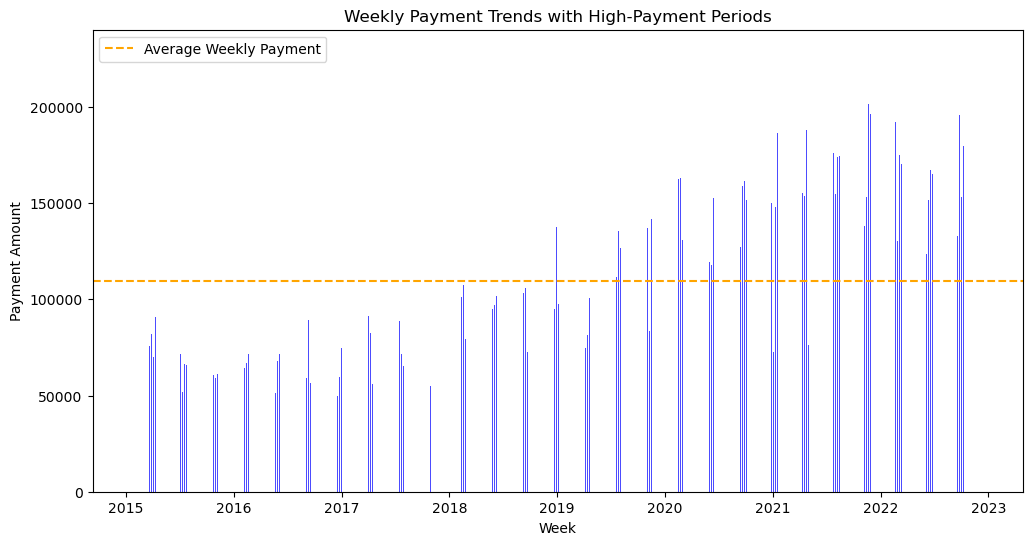

In [134]:

plt.figure(figsize=(12, 6))
plt.bar(weekly_payment.index, weekly_payment['Payment Amount'], color='blue', alpha=0.7)
plt.axhline(y=weekly_payment['Payment Amount'].mean(), color='orange', linestyle='--', label='Average Weekly Payment')
plt.title("Weekly Payment Trends with High-Payment Periods")
plt.xlabel("Week")
plt.ylabel("Payment Amount")
plt.legend()
plt.show()

In [138]:

result = adfuller(weekly_payment.dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] > 0.05:
    print("Data is non-stationary. Differencing is required.")
else:
    print("Data is stationary. Proceed with ARIMA.")

ADF Statistic: -0.42703139067985035
p-value: 0.9054867333669796
Data is non-stationary. Differencing is required.


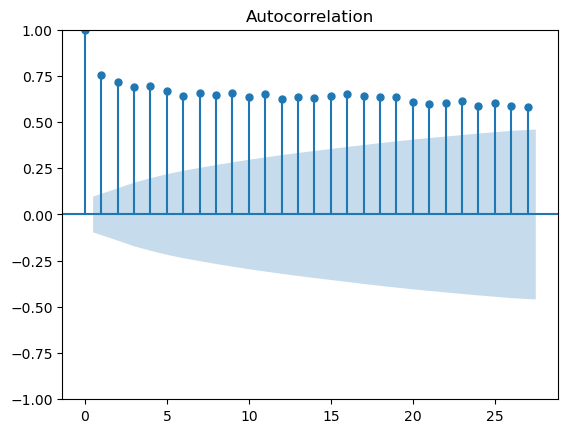

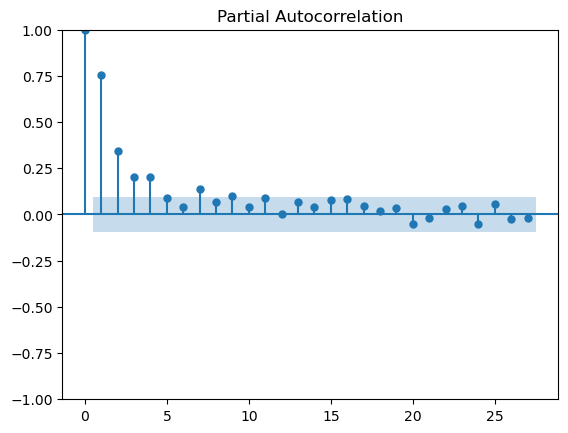

In [140]:

plot_acf(weekly_payment.dropna())
plot_pacf(weekly_payment.dropna())
plt.show()

In [142]:
differenced_data = weekly_payment.diff().dropna()

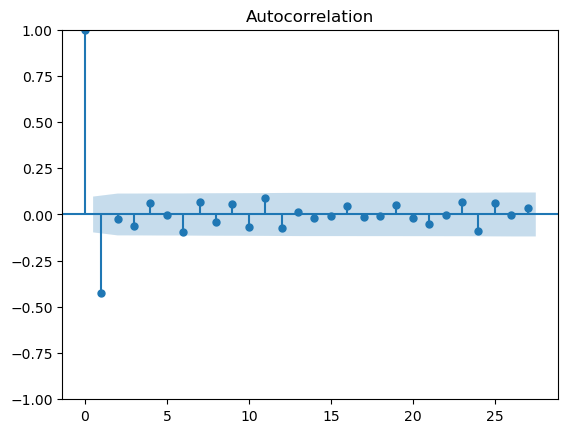

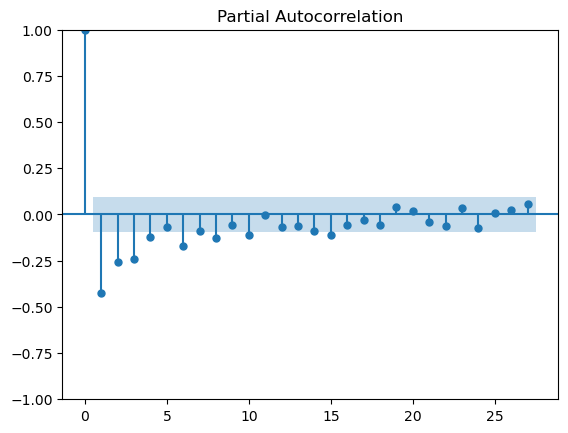

In [144]:
plot_acf(differenced_data.dropna())
plot_pacf(differenced_data.dropna())
plt.show()

In [146]:

# Fit the ARIMA model
model = ARIMA(weekly_payment['Payment Amount'], order=(1, 1, 1))
fitted_model = model.fit()


# Forecast for 12 periods
forecast = fitted_model.get_forecast(steps=12)
forecasted_data = forecast.summary_frame()  # Includes yhat, lower, and upper confidence intervals
forecasted_data.columns = ['yhat', 'yhat_se', 'yhat_lower', 'yhat_upper']



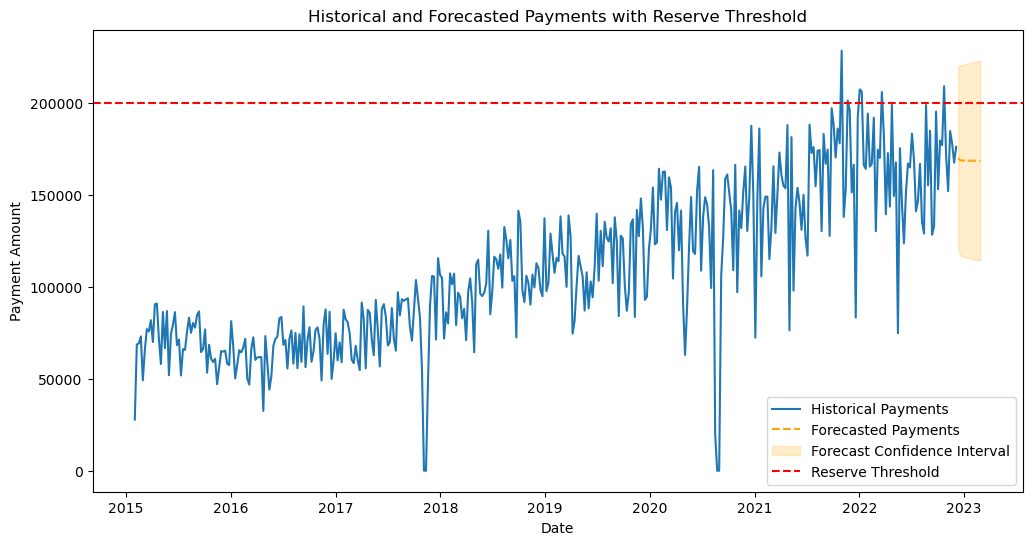

In [148]:
plt.figure(figsize=(12, 6))
plt.plot(weekly_payment.index, weekly_payment['Payment Amount'], label='Historical Payments')
plt.plot(forecasted_data.index, forecasted_data['yhat'], label='Forecasted Payments', linestyle='--', color='orange')
plt.fill_between(forecasted_data.index, forecasted_data['yhat_lower'], forecasted_data['yhat_upper'], color='orange', alpha=0.2, label='Forecast Confidence Interval')
reserve_threshold = 200000 
plt.axhline(y=reserve_threshold, color='red', linestyle='--', label='Reserve Threshold')
plt.title("Historical and Forecasted Payments with Reserve Threshold")
plt.xlabel("Date")
plt.ylabel("Payment Amount")
plt.legend()
plt.show()

# Supplier Specific Invoice and Payment Forecasting 

In [152]:
# Merge invoice and payment data on Invoice ID
merged_data = pd.merge(supplier_invoices_df, payment_details_df, on='Invoice ID', how='left')

# Aggregate payment details for each invoice
merged_data['Total Payments'] = merged_data.groupby('Invoice ID')['Payment Amount'].transform('sum')
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46228 entries, 0 to 46227
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Supplier Name      46228 non-null  object        
 1   Invoice ID         46228 non-null  object        
 2   Company            46228 non-null  object        
 3   Currency           46228 non-null  object        
 4   Item               46228 non-null  object        
 5   Quantity           46228 non-null  int64         
 6   Category           46228 non-null  object        
 7   Payee Type         46228 non-null  object        
 8   Supplier Rating    46228 non-null  object        
 9   Urgency            46228 non-null  object        
 10  Invoice Date       46228 non-null  datetime64[ns]
 11  Invoice Amount     46228 non-null  float64       
 12  Payment Term Days  46228 non-null  int64         
 13  Payment Status     46228 non-null  object        
 14  Invoic

In [170]:
# Supplier-level aggregation
supplier_summary = merged_data.groupby('Supplier Name').agg({
    'Invoice Amount': 'sum',
    'Total Payments': 'sum'
}).reset_index()

# Calculate outstanding balance
supplier_summary['Outstanding Balance'] = supplier_summary['Invoice Amount'] - supplier_summary['Total Payments']


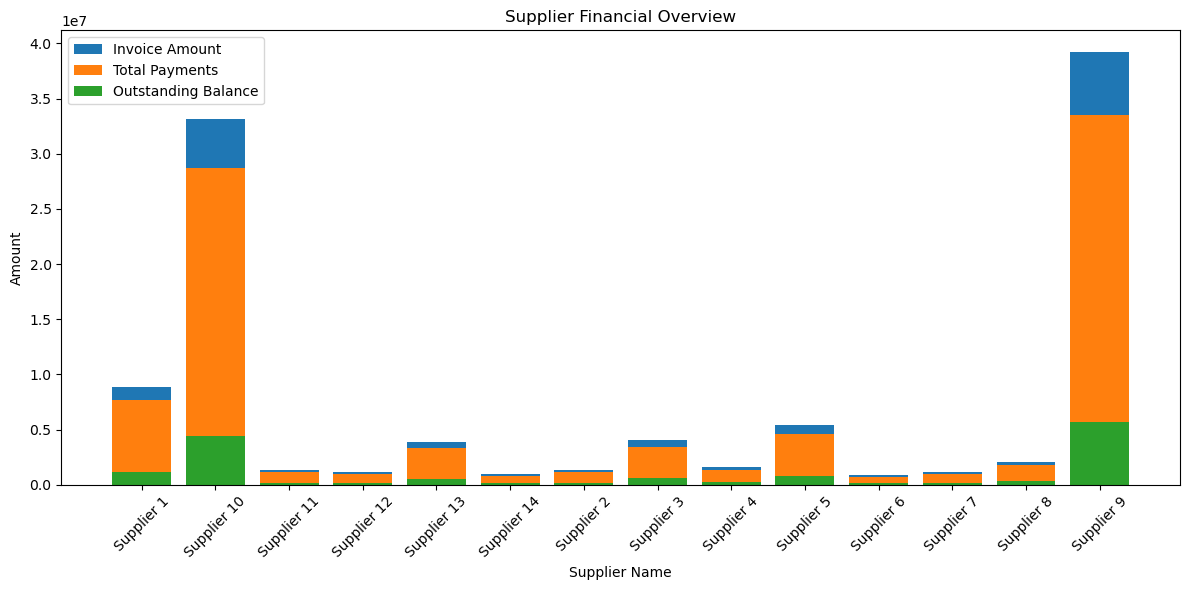

In [156]:
plt.figure(figsize=(12, 6))
plt.bar(supplier_summary["Supplier Name"], supplier_summary["Invoice Amount"], label="Invoice Amount")
plt.bar(supplier_summary["Supplier Name"], supplier_summary["Total Payments"], label="Total Payments")
plt.bar(supplier_summary["Supplier Name"], supplier_summary["Outstanding Balance"], label="Outstanding Balance")
plt.title("Supplier Financial Overview")
plt.xlabel("Supplier Name")
plt.ylabel("Amount")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [160]:
# Calculate payment frequency and time to complete payments
payment_analysis = merged_data.groupby('Invoice ID').agg({
    'Invoice Date': ['min', 'max'],
    'Payment Amount': 'count'  # Number of partial payments
}).reset_index()

# Calculate payment duration
payment_analysis['Payment Duration (Days)'] = (
    payment_analysis[('Invoice Date', 'max')] - payment_analysis[('Invoice Date', 'min')]
).dt.days

In [166]:
merged_data['Invoice Date'] = pd.to_datetime(merged_data['Invoice Date'], errors='coerce')
# Filter for a specific supplier
supplier_data = merged_data[merged_data['Supplier Name'] == 'Supplier 10']
supplier_data.set_index('Invoice Date', inplace=True)

supplier_time_series = supplier_data.groupby(pd.Grouper(freq='M')).agg({
    'Invoice Amount': 'sum',
    'Total Payments': 'sum'
})

# Forecast invoice trends using ARIMA
model = ARIMA(supplier_time_series['Invoice Amount'], order=(1, 1, 1))
supplier_model = model.fit()

# Forecast the next 12 months
forecast = supplier_model.forecast(steps=12)


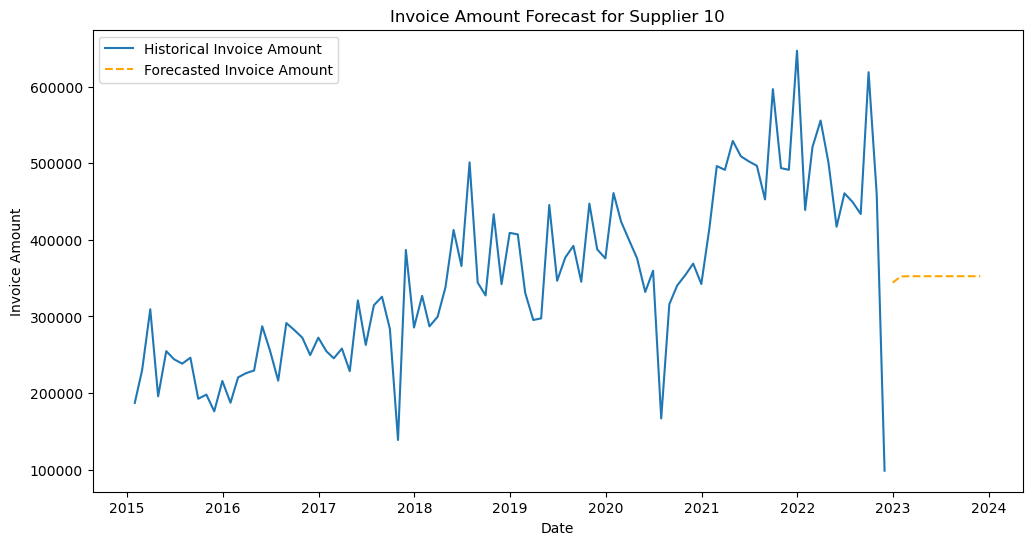

In [183]:
# Create forecast index (next 12 months)
forecast_index = pd.date_range(start=supplier_time_series.index[-1], periods=12 + 1, freq='M')[1:]

# Plot historical data
plt.figure(figsize=(12, 6))
plt.plot(supplier_time_series.index, supplier_time_series['Invoice Amount'], label='Historical Invoice Amount')

# Plot forecasted data
plt.plot(forecast_index, forecast, label='Forecasted Invoice Amount', linestyle='--', color='orange')

# Add labels and legend
plt.title("Invoice Amount Forecast for Supplier 10")
plt.xlabel("Date")
plt.ylabel("Invoice Amount")
plt.legend()
plt.show()

In [176]:
supplier_9_invoices = supplier_invoices_df[supplier_invoices_df['Supplier Name'] == 'Supplier 9']
supplier_6_invoices = supplier_invoices_df[supplier_invoices_df['Supplier Name'] == 'Supplier 6']

#### XGBoost/Prophet Model on Invoices related to Supplier 9

In [294]:

supplier_9_invoices['Invoice Date'] = pd.to_datetime(supplier_9_invoices['Invoice Date'])

supplier_9_invoices.set_index('Invoice Date', inplace=True)

aggregated_supplier9 = supplier_9_invoices.resample('D').sum().reset_index()

aggregated_supplier9 = aggregated_supplier9[aggregated_supplier9['Supplier Name'] == 'Supplier 9']



,Invoice Date,Supplier Name,Invoice ID,Company,Currency,Item,Quantity,Category,Payee Type,Supplier Rating,Urgency,Invoice Amount,Payment Term Days,Payment Status,Invoice Year
0,2015-01-01,Supplier 9,INV13702619827014237,Company A,USD,Beverages,3025,Consulting,Supplier,Low,Normal,6394.19,45,Paid,2015
1,2015-01-02,Supplier 9,INV12415725280831716,Company A,USD,Beverages,6843,Consulting,Contingent Worker,Low,Normal,6267.79,90,Paid,2015
4,2015-01-05,Supplier 9,INV51289740438169336,Company A,USD,Beverages,10690,Materials,Supplier,Medium,High,6354.82,30,Paid,2015
5,2015-01-06,Supplier 9,INV73442106977230088,Company A,USD,Chairs,13159,IT Services,Ad Hoc Payee,Medium,Normal,6234.60,90,Paid,2015
6,2015-01-07,Supplier 9,INV60454673725161540,Company A,USD,Desk,35673,Consulting,Contingent Worker,High,High,6256.05,45,Partially Paid,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2860,2022-10-31,Supplier 9,INV53375119286285334,Company A,USD,Monitor,79555,Materials,Contingent Worker,High,Normal,20445.04,90,Paid,2022
2861,2022-11-01,Supplier 9,INV44390995390889102,Company A,USD,Chairs,39706,Materials,Contingent Worker,Medium,High,20650.92,90,Paid,2022
2862,2022-11-02,Supplier 9,INV31770174685386676,Company A,USD,Desk,43317,Marketing,Ad Hoc Payee,Medium,Normal,20691.25,60,Partially Paid,2022
2863,2022-11-03,Supplier 9,INV11268151320542346,Company A,USD,Food,35328,Consulting,Supplier,High,High,20247.06,60,Unpaid,2022


In [296]:
# Feature preparation

X_encoded = pd.get_dummies(aggregated_supplier9[['Category', 'Payee Type', 'Payment Status']], drop_first=True)
y = aggregated_supplier9['Invoice Amount']
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, shuffle=False)

model = XGBRegressor()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print("RMSE:", mean_squared_error(y_test, predictions, squared=False))

RMSE: 8741.365078169816


22:20:43 - cmdstanpy - INFO - Chain [1] start processing
22:20:44 - cmdstanpy - INFO - Chain [1] done processing


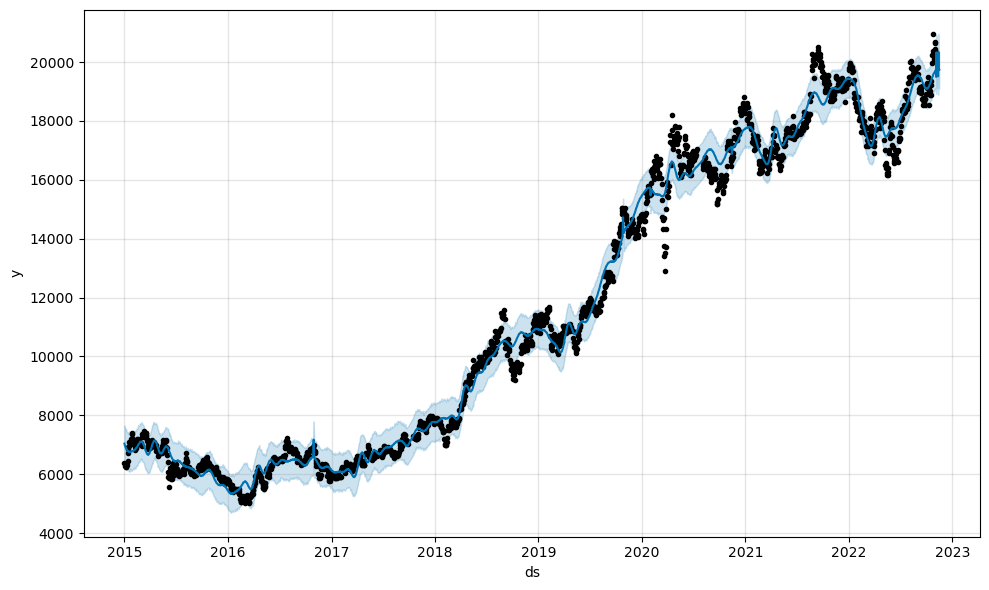

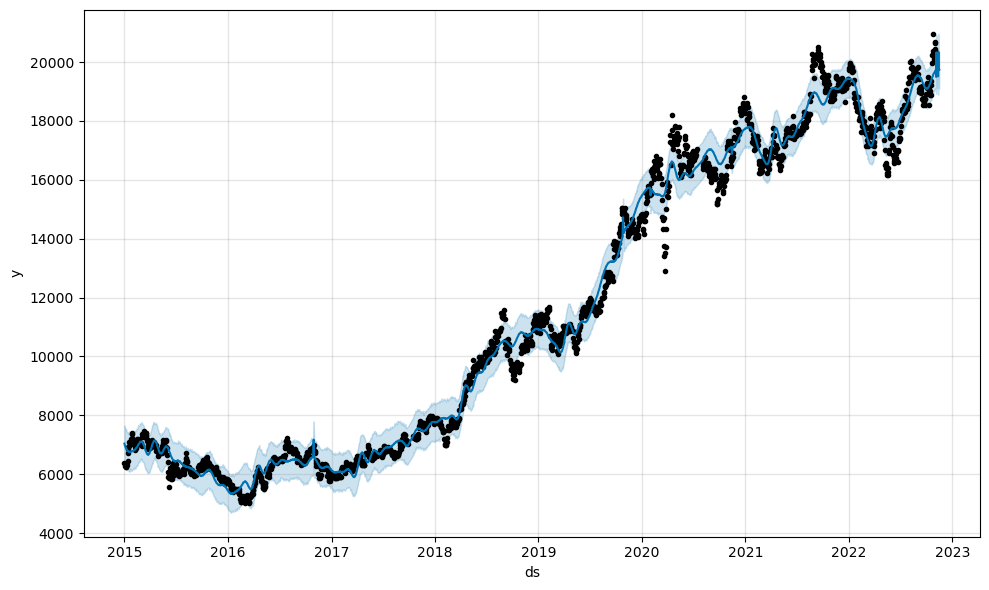

In [298]:
from prophet import Prophet

# Prepare data for Prophet
prophet_data = aggregated_supplier9[['Invoice Date', 'Invoice Amount']].rename(columns={'Invoice Date': 'ds', 'Invoice Amount': 'y'})

model = Prophet()
model.add_seasonality(name='daily', period=365, fourier_order=5)
model.fit(prophet_data)

future = model.make_future_dataframe(periods=12, freq='D')
forecast = model.predict(future)

model.plot(forecast)

22:22:52 - cmdstanpy - INFO - Chain [1] start processing
22:22:52 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 1193.040209585796


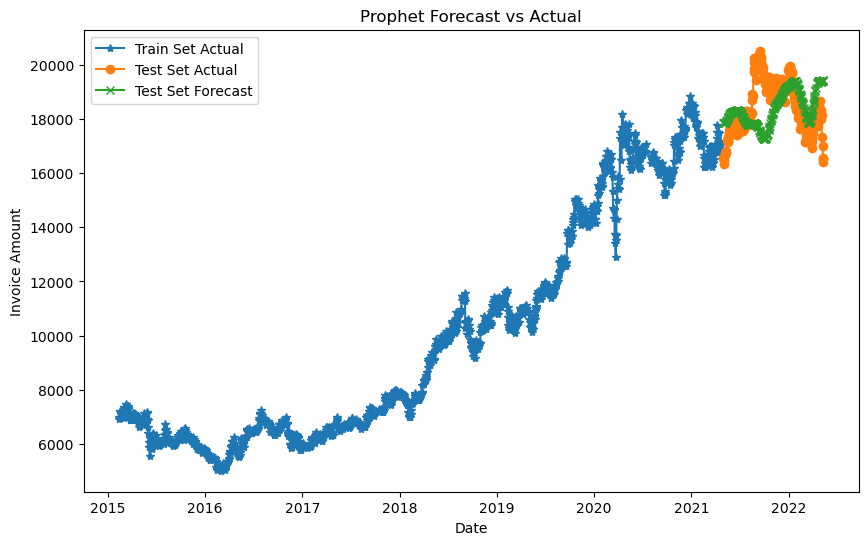

In [311]:
# Define split point
split_point = int(len(aggregated_supplier9) * 0.8)  # Use 80% for training

# Train and test split
train = aggregated_supplier9.iloc[:split_point]
test = aggregated_supplier9.iloc[split_point:]

prophet_data = train[['Invoice Date', 'Invoice Amount']].rename(columns={'Invoice Date': 'ds', 'Invoice Amount': 'y'})

model = Prophet()
model.add_seasonality(name='daily', period=365, fourier_order=5)
model.fit(prophet_data)

# Create future dataframe including test dates
future = model.make_future_dataframe(periods=len(test), freq='D')

# Predict values
forecast = model.predict(future)

# Filter forecast for test period
# Rename test columns to match Prophet's format
test = test.rename(columns={'Invoice Date': 'ds', 'Invoice Amount': 'y'})

# Ensure proper alignment of forecast dates with test dates
forecast_test = forecast[forecast['ds'].isin(test['ds'])]

# Re-align forecast_test with test by using intersection of dates
common_dates = forecast_test['ds'].tolist()
test = test[test['ds'].isin(common_dates)]
forecast_test = forecast_test[forecast_test['ds'].isin(test['ds'])]

# Reset indices to ensure alignment
forecast_test = forecast_test.set_index('ds').loc[test['ds']].reset_index()

# Compare actual vs predicted
comparison = test.copy()
comparison['yhat'] = forecast_test['yhat'].values


# Compare actual vs predicted
comparison = test.copy()
comparison['yhat'] = forecast_test['yhat'].values

rmse = mean_squared_error(comparison['y'], comparison['yhat'], squared=False)
print("RMSE:", rmse)

plt.figure(figsize=(10, 6))
plt.plot(prophet_data['ds'], prophet_data['y'], label='Train Set Actual', marker='*')
plt.plot(test['ds'], test['y'], label='Test Set Actual', marker='o')
plt.plot(test['ds'], comparison['yhat'], label='Test Set Forecast', marker='x')
plt.xlabel('Date')
plt.ylabel('Invoice Amount')
plt.title('Prophet Forecast vs Actual')
plt.legend()
plt.show()

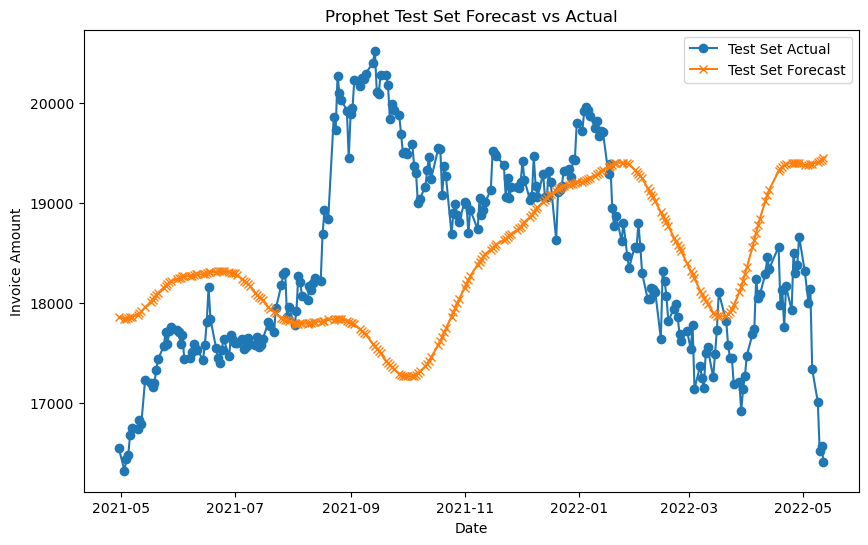

In [313]:
plt.figure(figsize=(10, 6))
plt.plot(test['ds'], test['y'], label='Test Set Actual', marker='o')
plt.plot(test['ds'], comparison['yhat'], label='Test Set Forecast', marker='x')
plt.xlabel('Date')
plt.ylabel('Invoice Amount')
plt.title('Prophet Test Set Forecast vs Actual')
plt.legend()
plt.show()

22:23:07 - cmdstanpy - INFO - Chain [1] start processing
22:23:07 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 272.4380126809856


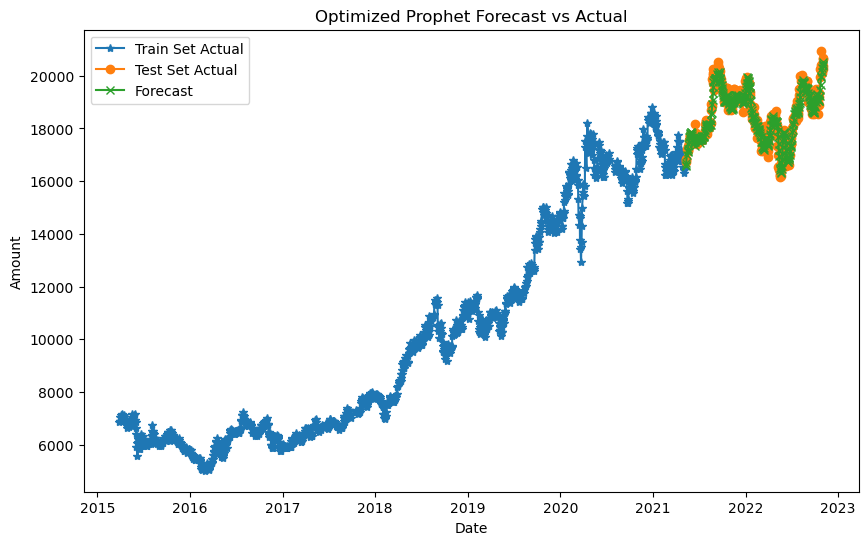

In [315]:
aggregated_supplier9['Invoice Date'] = pd.to_datetime(aggregated_supplier9['Invoice Date'])

aggregated_supplier9['MA_7'] = aggregated_supplier9['Invoice Amount'].rolling(window=7).mean()
aggregated_supplier9['MA_30'] = aggregated_supplier9['Invoice Amount'].rolling(window=30).mean()

def calculate_rsi(data, window=14):
    delta = data.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

aggregated_supplier9['RSI_14'] = calculate_rsi(aggregated_supplier9['Invoice Amount'], window=14)

aggregated_supplier9 = aggregated_supplier9.dropna()

split_point = int(len(aggregated_supplier9) * 0.8)  # Use 80% for training
train = aggregated_supplier9.iloc[:split_point]
test = aggregated_supplier9.iloc[split_point:]

train = train.rename(columns={'Invoice Date': 'ds', 'Invoice Amount': 'y'})
test = test.rename(columns={'Invoice Date': 'ds', 'Invoice Amount': 'y'})

model = Prophet()
model.add_regressor('MA_7')
model.add_regressor('MA_30')
model.add_regressor('RSI_14')

model.fit(train[['ds', 'y', 'MA_7', 'MA_30', 'RSI_14']])

future = test[['ds']].copy()  
future['MA_7'] = test['MA_7']
future['MA_30'] = test['MA_30']
future['RSI_14'] = test['RSI_14']

forecast = model.predict(future)


comparison = test.copy()

# Ensure forecast and test align by using the 'ds' column
forecast_filtered = forecast[forecast['ds'].isin(comparison['ds'])]

# Align the indices of forecast and test based on 'ds'
forecast_filtered = forecast_filtered.set_index('ds').loc[comparison['ds']].reset_index()

# Assign forecasted values (yhat) to the comparison dataframe
comparison['yhat'] = forecast_filtered['yhat'].values

rmse = mean_squared_error(comparison['y'], comparison['yhat'], squared=False)
print(f"RMSE: {rmse}")


plt.figure(figsize=(10, 6))
plt.plot(train['ds'], train['y'], label='Train Set Actual', marker='*')
plt.plot(test['ds'], test['y'], label='Test Set Actual', marker='o')
plt.plot(test['ds'], comparison['yhat'], label='Forecast', marker='x')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.title('Optimized Prophet Forecast vs Actual')
plt.legend()
plt.show()

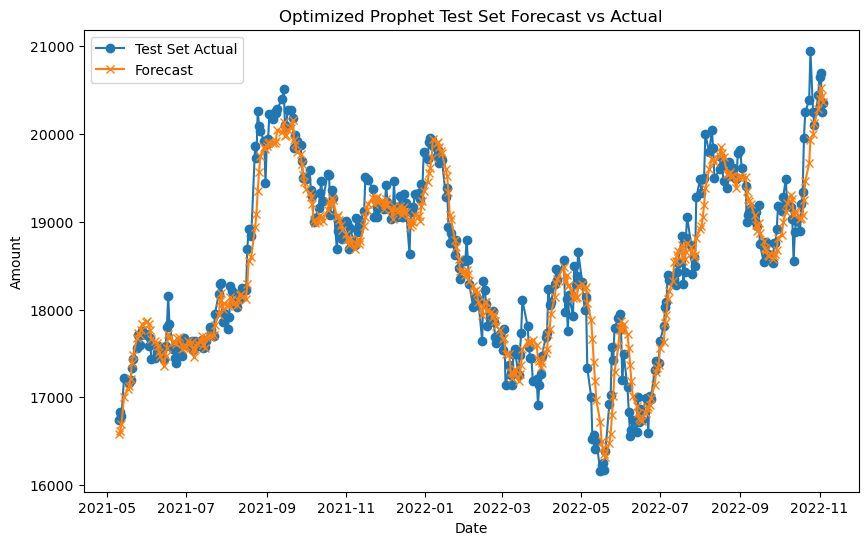

In [317]:
plt.figure(figsize=(10, 6))
plt.plot(test['ds'], test['y'], label='Test Set Actual', marker='o')
plt.plot(test['ds'], comparison['yhat'], label='Forecast', marker='x')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.title('Optimized Prophet Test Set Forecast vs Actual')
plt.legend()
plt.show()

In [292]:
supplier_6_invoices['Invoice Date'] = pd.to_datetime(supplier_6_invoices['Invoice Date'])

supplier_6_invoices.set_index('Invoice Date', inplace=True)

aggregated_supplier6 = supplier_6_invoices.resample('D').sum().reset_index()

aggregated_supplier6 = aggregated_supplier6[aggregated_supplier6['Supplier Name'] == 'Supplier 6']


,Invoice Date,Supplier Name,Invoice ID,Company,Currency,Item,Quantity,Category,Payee Type,Supplier Rating,Urgency,Invoice Amount,Payment Term Days,Payment Status,Invoice Year
0,2015-01-01,Supplier 6,INV94363306750697621,Company A,USD,Food,2538978,Consulting,Ad Hoc Payee,High,High,245.74,60,Partially Paid,2015
1,2015-01-02,Supplier 6,INV02403850127602076,Company A,USD,Laptop,6599676,Consulting,Supplier,Low,Normal,246.59,90,Paid,2015
4,2015-01-05,Supplier 6,INV44639270017580001,Company A,USD,Desk,8238987,IT Services,Contingent Worker,Medium,Normal,247.16,90,Unpaid,2015
5,2015-01-06,Supplier 6,INV45079980775734796,Company A,USD,Food,13093040,Marketing,Supplier,Low,High,245.93,45,Paid,2015
6,2015-01-07,Supplier 6,INV79747782301641385,Company A,USD,Food,11960580,IT Services,Contingent Worker,Medium,High,237.60,45,Unpaid,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2860,2022-10-31,Supplier 6,INV90024661359158689,Company A,USD,Laptop,13825970,Marketing,Contingent Worker,Medium,Normal,345.57,90,Partially Paid,2022
2861,2022-11-01,Supplier 6,INV55836535133473637,Company A,USD,Desk,19665200,IT Services,Supplier,Medium,High,347.82,90,Paid,2022
2862,2022-11-02,Supplier 6,INV93720507856799500,Company A,USD,Laptop,16781507,Materials,Ad Hoc Payee,High,High,351.05,45,Unpaid,2022
2863,2022-11-03,Supplier 6,INV78672328180584641,Company A,USD,Desk,10736155,Consulting,Supplier,High,Normal,353.35,45,Partially Paid,2022


In [333]:
class SARIMAXWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), diff=False, seasonal_diff=False):
        self.order = order
        self.seasonal_order = seasonal_order
        self.diff = diff  # Enable differencing
        self.seasonal_diff = seasonal_diff  # Enable seasonal differencing
        self.model_ = None
        self.fitted_ = None
        self.differenced_data_ = None  # Store differenced data for prediction
    
    def difference(self, data, lag=1):
        # Perform simple differencing
        return data.diff(lag).dropna()
    
    def seasonal_difference(self, data, lag=12):
        # Perform seasonal differencing
        return data.diff(lag).dropna()
    
    def fit(self, X, y=None):
        # Apply differencing if enabled
        if self.diff:
            X = self.difference(X)
        if self.seasonal_diff:
            X = self.seasonal_difference(X)
        
        self.differenced_data_ = X  # Save differenced data for inverse transform
        
        # Fit SARIMAX model
        self.model_ = SARIMAX(X, order=self.order, seasonal_order=self.seasonal_order)
        self.fitted_ = self.model_.fit(disp=False)
        return self
    
    def predict(self, steps=10):
        # Forecast future steps
        forecast = self.fitted_.get_forecast(steps=steps)
        forecast_mean = forecast.predicted_mean
        
        # Undo differencing for forecasts
        if self.diff:
            forecast_mean = self.undo_difference(forecast_mean, steps)
        if self.seasonal_diff:
            forecast_mean = self.undo_seasonal_difference(forecast_mean, steps)
        
        return forecast_mean
    
    def undo_difference(self, forecast, steps):
        # Add back the last value of the original data for simple differencing
        last_value = self.differenced_data_.iloc[-1]
        forecast_cumsum = forecast.cumsum()
        return forecast_cumsum + last_value
    
    def undo_seasonal_difference(self, forecast, steps):
        # Add back the last seasonal value for seasonal differencing
        seasonal_lag = self.seasonal_order[-1]
        last_seasonal_value = self.differenced_data_.iloc[-seasonal_lag]
        forecast_cumsum = forecast.cumsum()
        return forecast_cumsum + last_seasonal_value
    
    def score(self, X, y=None):
        # Use RMSE as the scoring metric (lower is better)
        if y is not None:
            predictions = self.fitted_.fittedvalues
            return -mean_squared_error(y, predictions, squared=False)
        return -self.fitted_.aic  # Fallback to AIC if no ground truth is available



# Step 2: Load Data
data = aggregated_supplier6.rename(columns={"Invoice Date": "ds", "Amount": "y"})
train = data.iloc[:int(len(data) * 0.8)]
test = data.iloc[int(len(data) * 0.8):]

X_train = train["Invoice Amount"]  
X_test = test["Invoice Amount"]

# Step 3: Define Parameter Grid
param_grid = {
    'order': [(1, 1, 1), (2, 1, 2), (3, 1, 3), (1, 0, 1), (2, 0, 2)],
    'seasonal_order': [(1, 1, 1, 7), (1, 1, 1, 12), (1, 0, 1, 7), (1, 0, 1, 12), (2, 1, 2, 7), (2, 1, 2, 12), (3, 1, 3, 12)],
    'diff': [True, False],  
    'seasonal_diff': [True, False]  
}

# Step 4: Initialize GridSearchCV
sarimax_search = GridSearchCV(
    estimator=SARIMAXWrapper(),
    param_grid=param_grid,
    scoring="neg_mean_squared_error", 
    cv=3,
    verbose=2
)

# Step 5: Fit GridSearchCV
sarimax_search.fit(X_train)

# Best parameters and model
print("Best Parameters:", sarimax_search.best_params_)
best_model = sarimax_search.best_estimator_

# Step 6: Forecast with the Best Model
forecast_steps = len(X_test)
forecast = best_model.predict(steps=forecast_steps)

# Step 7: Evaluate and Plot
rmse = mean_squared_error(X_test, forecast, squared=False)
print(f"Test RMSE: {rmse}")



Fitting 3 folds for each of 140 candidates, totalling 420 fits
[CV] END diff=True, order=(1, 1, 1), seasonal_diff=True, seasonal_order=(1, 1, 1, 7); total time=   1.2s
[CV] END diff=True, order=(1, 1, 1), seasonal_diff=True, seasonal_order=(1, 1, 1, 7); total time=   1.1s
[CV] END diff=True, order=(1, 1, 1), seasonal_diff=True, seasonal_order=(1, 1, 1, 7); total time=   0.8s
[CV] END diff=True, order=(1, 1, 1), seasonal_diff=True, seasonal_order=(1, 1, 1, 12); total time=   2.2s
[CV] END diff=True, order=(1, 1, 1), seasonal_diff=True, seasonal_order=(1, 1, 1, 12); total time=   3.1s
[CV] END diff=True, order=(1, 1, 1), seasonal_diff=True, seasonal_order=(1, 1, 1, 12); total time=   3.0s
[CV] END diff=True, order=(1, 1, 1), seasonal_diff=True, seasonal_order=(1, 0, 1, 7); total time=   0.5s
[CV] END diff=True, order=(1, 1, 1), seasonal_diff=True, seasonal_order=(1, 0, 1, 7); total time=   0.5s
[CV] END diff=True, order=(1, 1, 1), seasonal_diff=True, seasonal_order=(1, 0, 1, 7); total ti

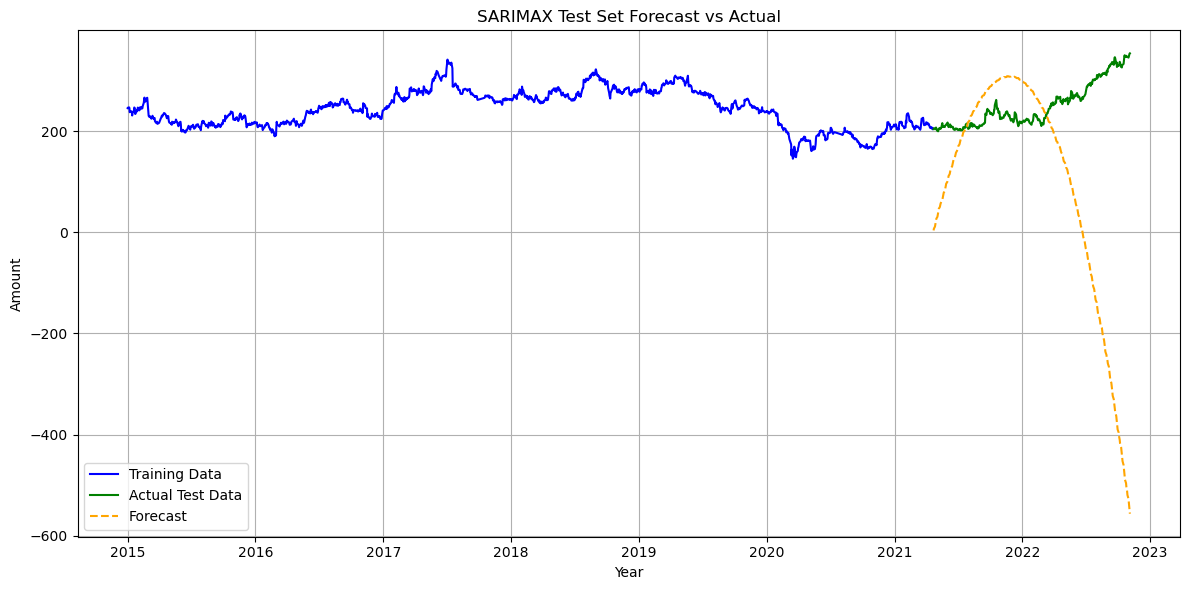

In [335]:
train.set_index("ds", inplace=True)
test.set_index("ds", inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(train.index, X_train, label="Training Data", color="blue")
plt.plot(test.index, X_test, label="Actual Test Data", color="green")
plt.plot(test.index, forecast, label="Forecast", color="orange", linestyle="--")
plt.title("SARIMAX Test Set Forecast vs Actual")
plt.xlabel("Year")
plt.ylabel("Amount")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

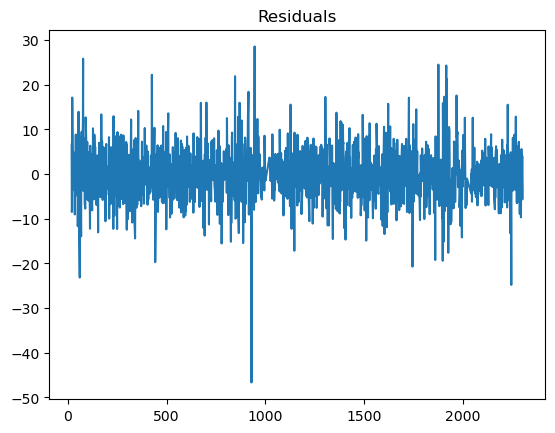

In [337]:
residuals = best_model.fitted_.resid
plt.plot(residuals)
plt.title("Residuals")
plt.show()

#### To Try for Payment Amount - Next Round

In [ ]:
# Fit SARIMA model
sarima_model = SARIMAX(filtered_data['Payment Amount'], 
                       order=(1, 1, 1),  # ARIMA parameters (p, d, q)
                       seasonal_order=(1, 1, 1, 12))  # Seasonal parameters (P, D, Q, s)
sarima_fitted = sarima_model.fit()

# Forecast
sarima_forecast = sarima_fitted.get_forecast(steps=365)
forecast_df = sarima_forecast.summary_frame()

last_date = payment_details_df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=365, freq='D')

# Plot
plt.figure(figsize=(12, 6))
plt.plot(filtered_data['Payment Amount'], label="Original Data")
plt.plot(future_dates, forecast_df['mean'], label="SARIMA Forecast", color='orange')
plt.fill_between(future_dates, forecast_df['mean_ci_lower'], forecast_df['mean_ci_upper'], color='orange', alpha=0.2)
plt.title("Forecast Using SARIMA")
plt.xlabel("Date")
plt.ylabel("Payment Amount")
plt.legend()
plt.show()